In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-malimg-xception-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = Xception(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 8394 samples, validate on 945 samples
Epoch 1/100
8394/8394 [==============================] - 127s - loss: 0.3020 - acc: 0.9148 - val_loss: 3.6373 - val_acc: 0.0106
Epoch 2/100
8394/8394 [==============================] - 124s - loss: 0.1266 - acc: 0.9583 - val_loss: 2.4310 - val_acc: 0.3926
Epoch 3/100
8394/8394 [==============================] - 125s - loss: 0.0958 - acc: 0.9683 - val_loss: 1.7148 - val_acc: 0.6656
Epoch 4/100
8394/8394 [==============================] - 124s - loss: 0.0811 - acc: 0.9738 - val_loss: 0.2267 - val_acc: 0.9323
Epoch 5/100
8394/8394 [==============================] - 125s - loss: 0.0967 - acc: 0.9689 - val_loss: 0.3416 - val_acc: 0.9175
Epoch 6/100
8394/8394 [==============================] - 125s - loss: 0.0780 - acc: 0.9740 - val_loss: 0.1496 - val_acc: 0.9598
Epoch 7/100
8394/8394 [==============================] - 125s - loss: 0.0738 - acc: 0.9765 - val_loss: 10.3977 - val_acc: 0.3069
Epoch 8/100
8394/8394 [==============================] -

8397/8397 [==============================] - 126s - loss: 0.0409 - acc: 0.9867 - val_loss: 0.0921 - val_acc: 0.9756
Epoch 25/100
8397/8397 [==============================] - 125s - loss: 0.0526 - acc: 0.9836 - val_loss: 0.0745 - val_acc: 0.9756
Epoch 26/100
8397/8397 [==============================] - 124s - loss: 0.0582 - acc: 0.9825 - val_loss: 0.3890 - val_acc: 0.8822
Epoch 27/100
8397/8397 [==============================] - 125s - loss: 0.0563 - acc: 0.9829 - val_loss: 0.0874 - val_acc: 0.9756
Epoch 28/100
8397/8397 [==============================] - 124s - loss: 0.0441 - acc: 0.9859 - val_loss: 0.3145 - val_acc: 0.8652
Epoch 29/100
8397/8397 [==============================] - 126s - loss: 0.0730 - acc: 0.9769 - val_loss: 0.4469 - val_acc: 0.8524
Epoch 30/100
8397/8397 [==============================] - 125s - loss: 0.0476 - acc: 0.9850 - val_loss: 1.4809 - val_acc: 0.8068
Epoch 31/100
8397/8397 [==============================] - 126s - loss: 0.0443 - acc: 0.9857 - val_loss: 0.0841

8401/8401 [==============================] - 125s - loss: 0.0028 - acc: 0.9989 - val_loss: 0.0554 - val_acc: 0.9893
Epoch 49/100
8401/8401 [==============================] - 125s - loss: 0.0108 - acc: 0.9965 - val_loss: 0.0520 - val_acc: 0.9872
Epoch 50/100
8401/8401 [==============================] - 125s - loss: 0.0057 - acc: 0.9983 - val_loss: 0.0489 - val_acc: 0.9936
Epoch 51/100
8401/8401 [==============================] - 125s - loss: 0.0054 - acc: 0.9988 - val_loss: 0.0770 - val_acc: 0.9893
Epoch 52/100
8401/8401 [==============================] - 125s - loss: 0.0044 - acc: 0.9986 - val_loss: 0.0612 - val_acc: 0.9840
Epoch 53/100
8401/8401 [==============================] - 126s - loss: 0.0079 - acc: 0.9982 - val_loss: 0.0766 - val_acc: 0.9840
Epoch 54/100
8401/8401 [==============================] - 125s - loss: 0.0053 - acc: 0.9979 - val_loss: 0.0685 - val_acc: 0.9893
Epoch 55/100
8401/8401 [==============================] - 125s - loss: 0.0100 - acc: 0.9975 - val_loss: 0.0963

8403/8403 [==============================] - 124s - loss: 0.0041 - acc: 0.9989 - val_loss: 0.0293 - val_acc: 0.9936
Epoch 73/100
8403/8403 [==============================] - 125s - loss: 8.7605e-04 - acc: 0.9998 - val_loss: 0.0206 - val_acc: 0.9947
Epoch 74/100
8403/8403 [==============================] - 125s - loss: 1.1521e-04 - acc: 1.0000 - val_loss: 0.0245 - val_acc: 0.9957
Epoch 75/100
8403/8403 [==============================] - 125s - loss: 1.5922e-04 - acc: 1.0000 - val_loss: 0.0232 - val_acc: 0.9957
Epoch 76/100
8403/8403 [==============================] - 125s - loss: 1.5896e-04 - acc: 1.0000 - val_loss: 0.0294 - val_acc: 0.9947
Epoch 77/100
8403/8403 [==============================] - 125s - loss: 9.8198e-05 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9957
Epoch 78/100
8403/8403 [==============================] - 124s - loss: 4.4227e-05 - acc: 1.0000 - val_loss: 0.0264 - val_acc: 0.9957
Epoch 79/100
8403/8403 [==============================] - 125s - loss: 2.9468e-05 - ac

8404/8404 [==============================] - 125s - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0725 - val_acc: 0.9861
Epoch 98/100
8404/8404 [==============================] - 125s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.1057 - val_acc: 0.9872
Epoch 99/100
8404/8404 [==============================] - 125s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0874 - val_acc: 0.9861
Epoch 100/100
928/935 [============================>.] - ETA: 0s[4] Test acurracy: 0.9850 (12530.5970 s)
Train on 8404 samples, validate on 935 samples
Epoch 1/100
8404/8404 [==============================] - 124s - loss: 1.7168 - acc: 0.6455 - val_loss: 1.2272 - val_acc: 0.7112
Epoch 2/100
8404/8404 [==============================] - 124s - loss: 0.6812 - acc: 0.8821 - val_loss: 0.7027 - val_acc: 0.9027
Epoch 3/100
8404/8404 [==============================] - 125s - loss: 0.4345 - acc: 0.9277 - val_loss: 0.3571 - val_acc: 0.9337
Epoch 4/100
8404/8404 [==============================] - 124s - loss: 0.2875 - acc: 0.9431

8408/8408 [==============================] - 126s - loss: 0.0519 - acc: 0.9839 - val_loss: 0.0669 - val_acc: 0.9796
Epoch 21/100
8408/8408 [==============================] - 126s - loss: 0.0352 - acc: 0.9869 - val_loss: 0.0537 - val_acc: 0.9860
Epoch 22/100
8408/8408 [==============================] - 125s - loss: 0.0173 - acc: 0.9945 - val_loss: 0.0809 - val_acc: 0.9817
Epoch 23/100
8408/8408 [==============================] - 126s - loss: 0.0497 - acc: 0.9880 - val_loss: 0.0493 - val_acc: 0.9839
Epoch 24/100
8408/8408 [==============================] - 127s - loss: 0.0283 - acc: 0.9946 - val_loss: 0.7895 - val_acc: 0.8045
Epoch 25/100
8408/8408 [==============================] - 126s - loss: 0.0145 - acc: 0.9941 - val_loss: 0.0353 - val_acc: 0.9903
Epoch 26/100
8408/8408 [==============================] - 125s - loss: 0.0068 - acc: 0.9979 - val_loss: 0.0313 - val_acc: 0.9893
Epoch 27/100
8408/8408 [==============================] - 125s - loss: 0.0145 - acc: 0.9957 - val_loss: 0.0480

8410/8410 [==============================] - 125s - loss: 0.0064 - acc: 0.9983 - val_loss: 0.4584 - val_acc: 0.8461
Epoch 46/100
8410/8410 [==============================] - 126s - loss: 0.0069 - acc: 0.9975 - val_loss: 0.0494 - val_acc: 0.9882
Epoch 47/100
8410/8410 [==============================] - 125s - loss: 0.0069 - acc: 0.9980 - val_loss: 0.0448 - val_acc: 0.9925
Epoch 48/100
8410/8410 [==============================] - 126s - loss: 0.0092 - acc: 0.9971 - val_loss: 0.8345 - val_acc: 0.8245
Epoch 49/100
8410/8410 [==============================] - 125s - loss: 0.0125 - acc: 0.9964 - val_loss: 0.4225 - val_acc: 0.9569
Epoch 50/100
8410/8410 [==============================] - 125s - loss: 0.0123 - acc: 0.9966 - val_loss: 0.0328 - val_acc: 0.9935
Epoch 51/100
8410/8410 [==============================] - 126s - loss: 0.0022 - acc: 0.9994 - val_loss: 0.0355 - val_acc: 0.9925
Epoch 52/100
8410/8410 [==============================] - 126s - loss: 3.7629e-04 - acc: 1.0000 - val_loss: 0.

8414/8414 [==============================] - 126s - loss: 0.0027 - acc: 0.9995 - val_loss: 0.0717 - val_acc: 0.9914
Epoch 70/100
8414/8414 [==============================] - 126s - loss: 3.0763e-04 - acc: 1.0000 - val_loss: 0.0750 - val_acc: 0.9903
Epoch 71/100
8414/8414 [==============================] - 127s - loss: 5.3094e-04 - acc: 0.9999 - val_loss: 0.0868 - val_acc: 0.9903
Epoch 72/100
8414/8414 [==============================] - 127s - loss: 0.0050 - acc: 0.9992 - val_loss: 0.2015 - val_acc: 0.9665
Epoch 73/100
8414/8414 [==============================] - 127s - loss: 0.0072 - acc: 0.9985 - val_loss: 0.0388 - val_acc: 0.9914
Epoch 74/100
8414/8414 [==============================] - 126s - loss: 7.3537e-04 - acc: 0.9998 - val_loss: 0.0488 - val_acc: 0.9924
Epoch 75/100
8414/8414 [==============================] - 127s - loss: 3.3370e-04 - acc: 1.0000 - val_loss: 0.0579 - val_acc: 0.9935
Epoch 76/100
8414/8414 [==============================] - 126s - loss: 9.5987e-05 - acc: 1.000

8416/8416 [==============================] - 127s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0212 - val_acc: 0.9924
Epoch 94/100
8416/8416 [==============================] - 126s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0226 - val_acc: 0.9924
Epoch 95/100
8416/8416 [==============================] - 127s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0246 - val_acc: 0.9913
Epoch 96/100
8416/8416 [==============================] - 127s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0235 - val_acc: 0.9924
Epoch 97/100
8416/8416 [==============================] - 126s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0242 - val_acc: 0.9924
Epoch 98/100
8416/8416 [==============================] - 126s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0254 - val_acc: 0.9924
Epoch 99/100
8416/8416 [==============================] - 125s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0261 - val_acc: 0.9924
Epoch 100/100
923/923 [==============================] - 4s     
[9] Test acurracy: 0.9924 (12623.6642 s)


In [ ]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9908


In [ ]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

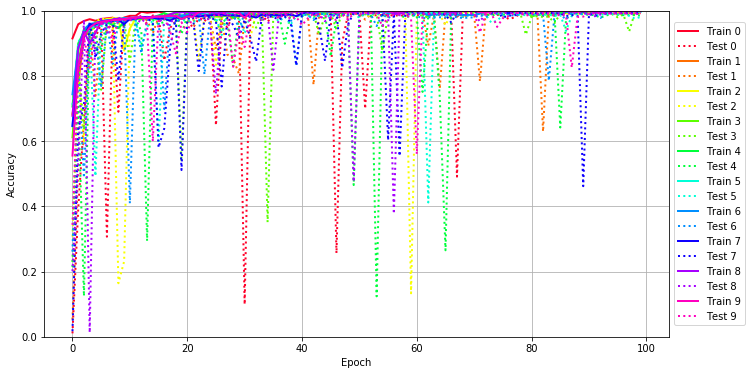

In [ ]:
plot_acc(history)

In [ ]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

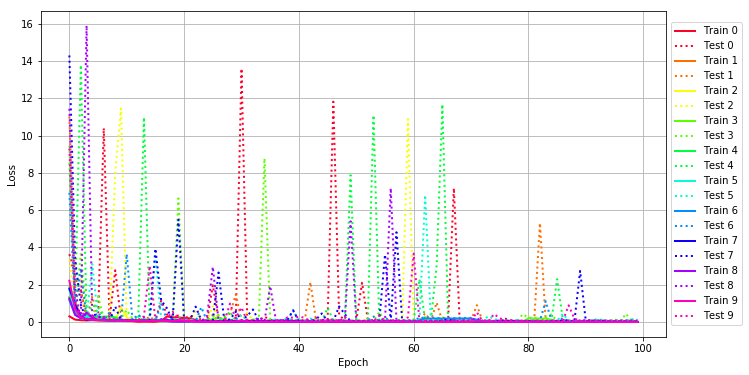

In [ ]:
plot_loss(history)

Plotting the confusion matrix


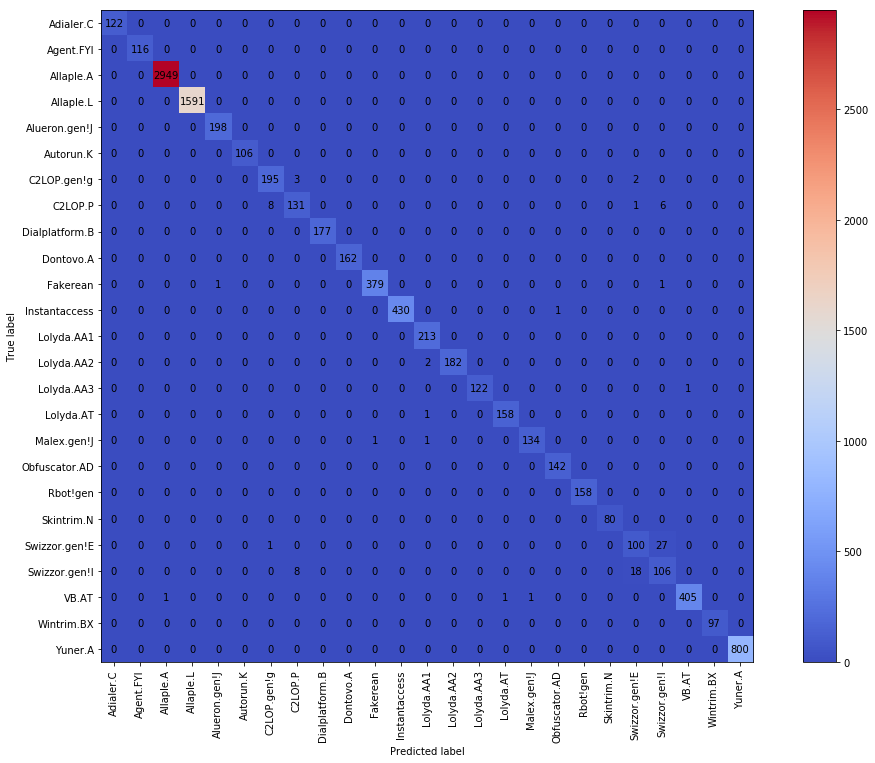

In [ ]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.imshow(conf_mat,interpolation='nearest',cmap='coolwarm')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


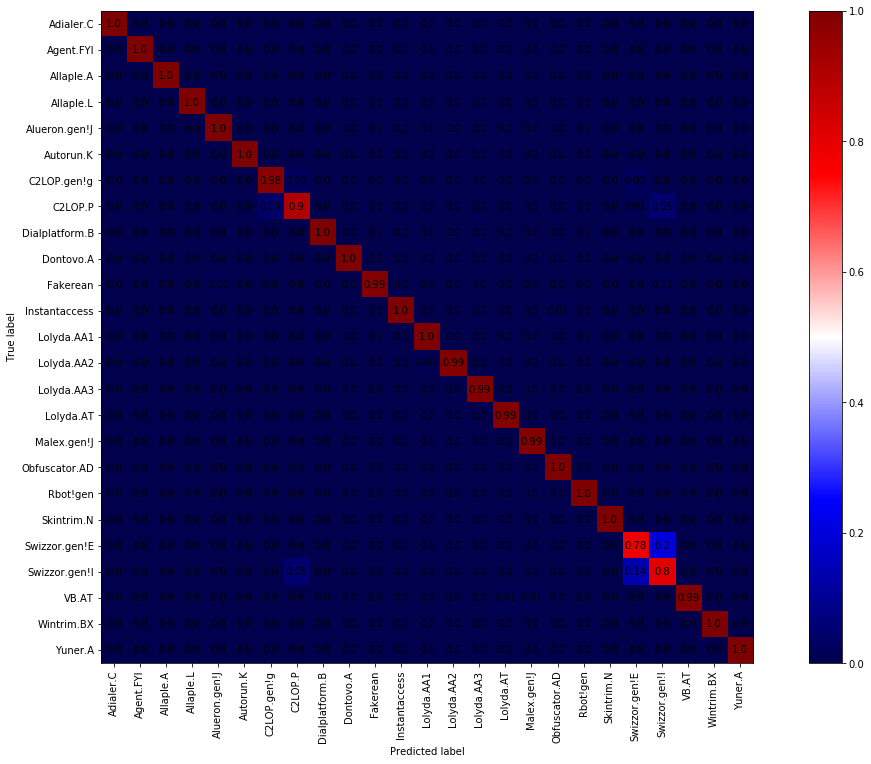

In [ ]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='seismic')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


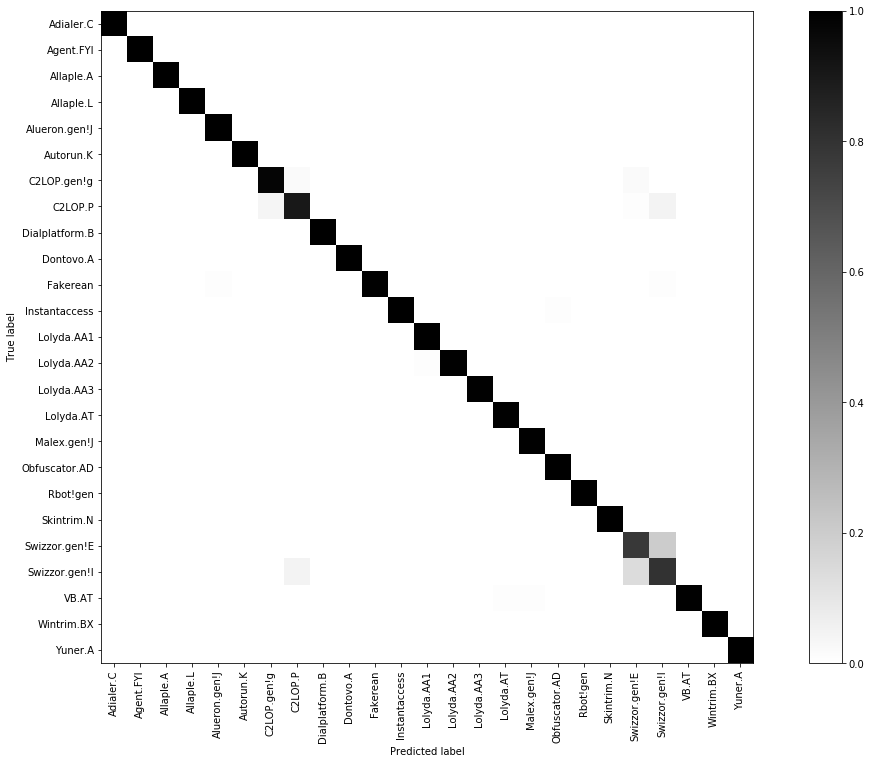

In [ ]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='binary')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


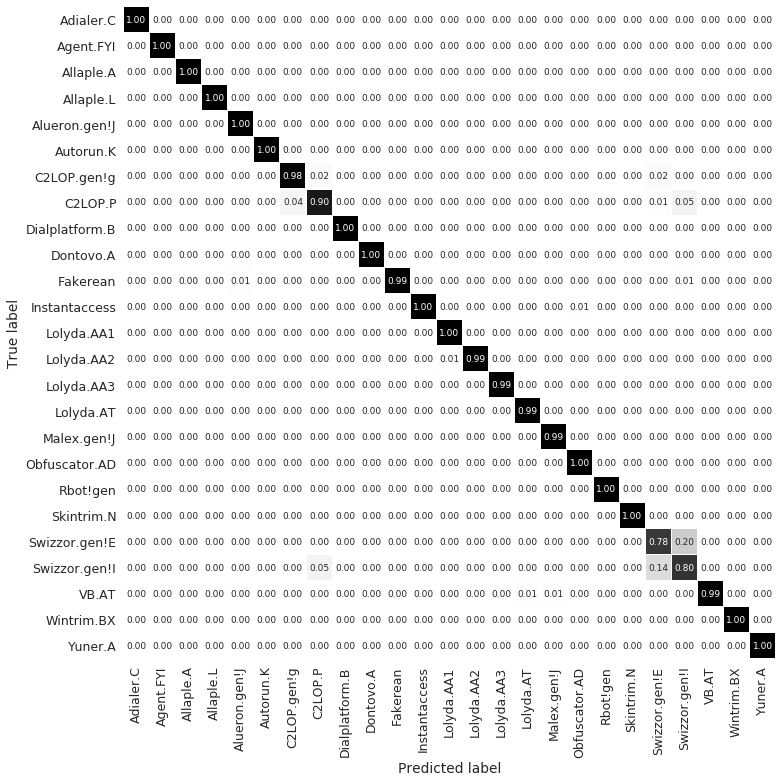

In [ ]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
for h in history:
    print(h.history)

{'val_loss': [3.6372553141659529, 2.4309601018668481, 1.7148380414045676, 0.22674258560282251, 0.34158895827988001, 0.14958698211247642, 10.397654397147042, 0.14392119469452608, 2.7724343619652374, 0.10330060698377604, 0.11314186606942669, 0.099051533238818795, 0.12714517199376479, 0.24225246348618837, 0.069079297390534894, 0.10673787962256154, 1.1465981770995386, 0.40814788823133874, 0.34214992075999673, 0.33913355398962552, 0.16230782739268002, 0.3465873205979218, 0.069650700617835376, 0.16973525543702606, 0.06661787905477852, 1.9723127325888392, 0.16924243612044038, 0.24098686821097395, 0.076434496178691871, 0.080138942236937516, 13.594559167932582, 0.068633893927279227, 0.07741711250268965, 0.076939660419928654, 0.28712067661559443, 0.11111761783885793, 0.074616068640359065, 0.08022063844018848, 0.095967750886062519, 0.08530443415631199, 0.11601079853021476, 0.084421838288114628, 0.082358156491274356, 0.079433247890640601, 0.0824952422885422, 0.082181090949528482, 11.82123506334092

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

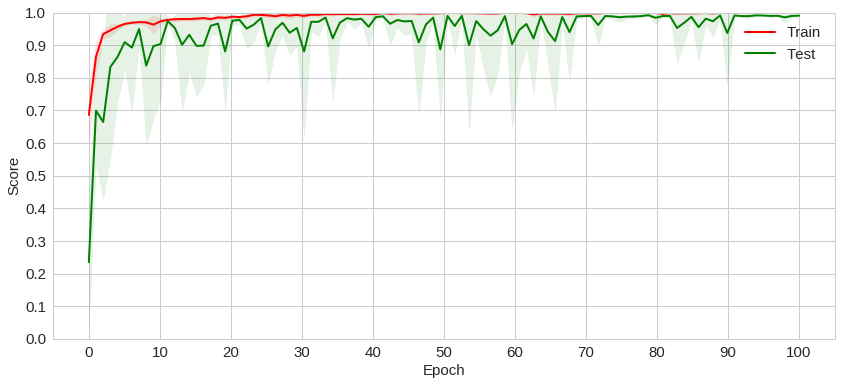

In [ ]:
plot_mean_acc(history)

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

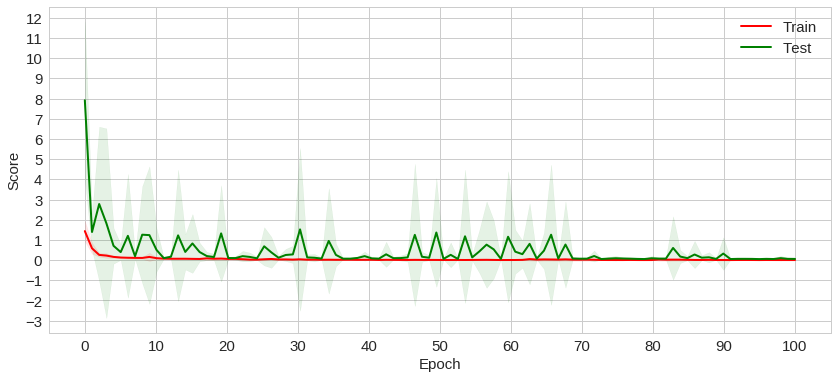

In [ ]:
plot_mean_loss(history)

In [4]:
history = [{'val_loss': [3.6372553141659529, 2.4309601018668481, 1.7148380414045676, 0.22674258560282251, 0.34158895827988001, 0.14958698211247642, 10.397654397147042, 0.14392119469452608, 2.7724343619652374, 0.10330060698377604, 0.11314186606942669, 0.099051533238818795, 0.12714517199376479, 0.24225246348618837, 0.069079297390534894, 0.10673787962256154, 1.1465981770995386, 0.40814788823133874, 0.34214992075999673, 0.33913355398962552, 0.16230782739268002, 0.3465873205979218, 0.069650700617835376, 0.16973525543702606, 0.06661787905477852, 1.9723127325888392, 0.16924243612044038, 0.24098686821097395, 0.076434496178691871, 0.080138942236937516, 13.594559167932582, 0.068633893927279227, 0.07741711250268965, 0.076939660419928654, 0.28712067661559443, 0.11111761783885793, 0.074616068640359065, 0.08022063844018848, 0.095967750886062519, 0.08530443415631199, 0.11601079853021476, 0.084421838288114628, 0.082358156491274356, 0.079433247890640601, 0.0824952422885422, 0.082181090949528482, 11.821235063340929, 0.39023385817324613, 0.072587345650891907, 0.069815127129509796, 0.077486475920553258, 2.1054160710292167, 0.13380477278918984, 0.088546772758515302, 0.085004619345784932, 0.085736068778919747, 0.0911267344738039, 0.091978058344704725, 0.093989943108909818, 0.086767219351040273, 0.08745252316620783, 0.088149739328132012, 0.088986805967392196, 0.089860453394337222, 0.088779946748889282, 0.093845933555808711, 0.093825703948044195, 7.1816108901861799, 0.11216364393596534, 0.099140432989974048, 0.076117703348570293, 0.093743404918508827, 0.082090192594705388, 0.074370536574023788, 0.077632760094587819, 0.091512252485680345, 0.17278852328013947, 0.10767601665693557, 0.063621947142810428, 0.060937048338541314, 0.055836892245969764, 0.056881282193187152, 0.1143487833802047, 0.075201110839037882, 0.085750585663926029, 0.060755049511268991, 0.067134043007141278, 0.067317022529725198, 0.067459039172828347, 0.068570457113668395, 0.068178169080332723, 0.068981232167196524, 0.067409652663370928, 0.068747030439475401, 0.069114409832957288, 0.070903629555440467, 0.071487505068926746, 0.07120202921174261, 0.072171658939340563, 0.073625863353749987], 'val_acc': [0.010582010582010581, 0.3925925925925926, 0.66560846560846565, 0.93227513227513226, 0.91746031746031742, 0.95978835978835975, 0.30687830687830686, 0.95978835978835975, 0.68994708994708998, 0.97460317460317458, 0.97460317460317458, 0.97354497354497349, 0.97671957671957677, 0.96084656084656084, 0.98518518518518516, 0.98306878306878309, 0.84761904761904761, 0.94708994708994709, 0.96825396825396826, 0.97037037037037033, 0.97248677248677251, 0.94708994708994709, 0.97566137566137567, 0.96719576719576716, 0.98835978835978833, 0.64867724867724863, 0.96296296296296291, 0.94920634920634916, 0.98624338624338626, 0.98624338624338626, 0.099470899470899474, 0.98518518518518516, 0.98730158730158735, 0.98730158730158735, 0.96613756613756618, 0.98518518518518516, 0.98518518518518516, 0.98518518518518516, 0.98624338624338626, 0.98412698412698407, 0.98624338624338626, 0.98835978835978833, 0.98730158730158735, 0.98730158730158735, 0.98835978835978833, 0.98835978835978833, 0.25608465608465608, 0.9015873015873016, 0.98835978835978833, 0.99153439153439149, 0.99047619047619051, 0.69947089947089947, 0.98412698412698407, 0.98624338624338626, 0.98624338624338626, 0.98624338624338626, 0.98518518518518516, 0.98518518518518516, 0.98518518518518516, 0.98730158730158735, 0.98624338624338626, 0.98730158730158735, 0.98730158730158735, 0.98624338624338626, 0.98730158730158735, 0.98624338624338626, 0.98730158730158735, 0.491005291005291, 0.98518518518518516, 0.98518518518518516, 0.98941798941798942, 0.98835978835978833, 0.98624338624338626, 0.98941798941798942, 0.98730158730158735, 0.98518518518518516, 0.97460317460317458, 0.97883597883597884, 0.99047619047619051, 0.99153439153439149, 0.99047619047619051, 0.99047619047619051, 0.98412698412698407, 0.98412698412698407, 0.98624338624338626, 0.99153439153439149, 0.99047619047619051, 0.99153439153439149, 0.99153439153439149, 0.99153439153439149, 0.99259259259259258, 0.99153439153439149, 0.99153439153439149, 0.99153439153439149, 0.99153439153439149, 0.99047619047619051, 0.99153439153439149, 0.99259259259259258, 0.99153439153439149, 0.99153439153439149], 'loss': [0.30202041368435362, 0.12660555115818609, 0.095831069174851291, 0.081089755403504132, 0.096668237107407587, 0.077989488856967701, 0.073837567401274576, 0.065667682087010279, 0.10146886595427876, 0.064902708112788768, 0.048250814188526642, 0.047776851045626234, 0.0099723276489753557, 0.021755223876857906, 0.015347671938424564, 0.0065924486321983387, 0.055617933674928663, 0.29517537419727741, 0.24967905135038163, 0.24549161920697443, 0.20566227826256089, 0.19714644626528108, 0.10496281589353618, 0.0050268172706003349, 0.0034093367697486101, 0.0033296693742940679, 0.048140552694069264, 0.010589288221687086, 0.0069422411652223072, 0.0055660732674650054, 0.033419702209019582, 0.015102843845476499, 0.0051606439158361269, 0.00080902448109454277, 0.019175355815071085, 0.0071752281576872058, 0.0042510187168955651, 0.014837293016410987, 0.0045510014052633644, 0.0069328734378470902, 0.0012789620187294397, 0.00058479587827992669, 0.00022770837504330915, 7.9349822662041125e-05, 3.6885132764000392e-05, 1.8518703707757259e-05, 0.0020996121636316857, 0.034704018564723119, 0.0070836657650046233, 0.0004812434394287414, 0.0026390881491249333, 0.0047338722116400129, 0.020435595213553016, 0.0027321549373463994, 0.00019283213127862687, 0.00010144865063566467, 6.2434063317240982e-05, 3.8029192558229173e-05, 3.5306252590659601e-05, 3.6366376782855672e-05, 2.0831436887700036e-05, 1.4089187701607511e-05, 1.0652581609018646e-05, 9.1528616524302363e-06, 2.0455091825630724e-05, 1.1741265319638416e-05, 1.7325110567800298e-05, 0.13286935578356263, 0.0090966912880325827, 0.0074211000775464128, 0.0018667973847487007, 0.00080310885505550261, 0.00019045215553178675, 9.6141009617026861e-05, 6.5261059808119094e-05, 0.00027830263262565533, 0.01099783028204949, 0.013960992390894727, 0.0028428480646073609, 0.00037189878963267387, 0.00010672329204205313, 0.00016879687663558999, 0.0034412773447804607, 0.00658208249431513, 0.0056273144246025229, 0.00042882764230584426, 9.5778750425987684e-05, 4.7040666255948324e-05, 2.993274359903139e-05, 3.0282824344939331e-05, 2.4075783295457836e-05, 1.2132366382227158e-05, 1.2121654266109502e-05, 9.2574894297645654e-06, 9.3703453210169511e-06, 1.3334337258084307e-05, 8.6812955828869922e-06, 6.5425201500656121e-06, 3.8852802479908912e-06, 4.5076962053321586e-06], 'acc': [0.9148201096020967, 0.95830355012646906, 0.96831069811770309, 0.97379080295449127, 0.96890636168691924, 0.97402906835377434, 0.97653085534448192, 0.97831784608053374, 0.97009768882535141, 0.97879437693590665, 0.98403621634500837, 0.98403621634500837, 0.99678341672623305, 0.99368596616630922, 0.99547295687395754, 0.99737908029544908, 0.99213724088634736, 0.97224207764612602, 0.98355968548963546, 0.98451274720038118, 0.98522754348344055, 0.98344055277579223, 0.983321420061949, 0.99857040743388137, 0.99892780557541105, 0.9991660710030974, 0.98629973790802949, 0.99666428401238982, 0.99725994758160585, 0.99821300929235168, 0.99225637360019059, 0.99487729330474151, 0.99857040743388137, 0.99976173457231354, 0.99571122230164399, 0.99714081486776274, 0.99892780557541105, 0.99535382416011442, 0.9986895401193211, 0.99749821300929231, 0.99952346914462709, 0.99964260185847031, 1.0, 1.0, 1.0, 1.0, 0.99928520371694063, 0.99106504646175841, 0.99737908029544908, 1.0, 0.99928520371694063, 0.99880867286156783, 0.99416249702168213, 0.99928520371694063, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98141529664045746, 0.99714081486776274, 0.99797474386466523, 0.99952346914462709, 0.99976173457231354, 1.0, 1.0, 1.0, 1.0, 0.99737908029544908, 0.99547295687395754, 0.99892780557541105, 1.0, 1.0, 1.0, 0.99845127472003814, 0.99773647843697877, 0.99833214200619491, 0.99988086728615677, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 
{'val_loss': [11.015299017515405, 1.8765775403146279, 1.5923160128394289, 0.13437581332692292, 1.3751926120447742, 0.21407329388590501, 0.14361403153402738, 0.11307518062093765, 0.14745798538465671, 0.081220463629912878, 0.076602689100728968, 0.076735847682506103, 0.065056064262685689, 0.08296200953768125, 0.28813935466102797, 0.064947617810124814, 0.081286653699585557, 0.072880564334200384, 0.073191965599838663, 0.063582232455780818, 0.12141375457841197, 0.099401034052336995, 0.062319604672254392, 0.092060813534702995, 0.074489948960016386, 0.38895649235204699, 0.087413009798578231, 0.31453138179402312, 0.44690498889756913, 1.4809135995634768, 0.084103532233766098, 0.087500276131283986, 0.028584061162971325, 0.06132814653860004, 0.064005175950954771, 0.066596628458402501, 0.039532283227443517, 0.043457038074000059, 0.031173109507932697, 0.029113950825316516, 0.044422631001041525, 0.049747986992097697, 2.1407727383005342, 0.037924440668025847, 0.022983009297029004, 0.036474322624693287, 0.026069107955443507, 0.026204366945904244, 0.025778685148067262, 0.071074224600047822, 0.043093894924736066, 0.11709892051839708, 0.046637027218457951, 0.03266055439549425, 0.033583887522543168, 0.033038591710307111, 0.035659707647130799, 0.03511277267733981, 0.035188081666742109, 0.036708275373744582, 0.035877908981386326, 0.036232886239811093, 0.46962272461366322, 0.059037660122337896, 1.0421989621388341, 0.027675301157078409, 0.032615466439781256, 0.028988585015962881, 0.12031772399740333, 0.07085009038768468, 0.080232895907701968, 0.90237371006717315, 0.052266485065264399, 0.047440438429336734, 0.034440483476100875, 0.034443936745211137, 0.045848608062824363, 0.046204206464856019, 0.046835527130345361, 0.046683868229901331, 0.046029929343814412, 0.051716195363380194, 5.3049071987761538, 0.0332921608474228, 0.034539125045639711, 0.046129357678047066, 0.047255839220897801, 0.043164549203485524, 0.044318058566903872, 0.041541796884289522, 0.036527536085735501, 0.035431112807383647, 0.03582043924188838, 0.044824175543005759, 0.047667869519995104, 0.043141919538130964, 0.042497101330761733, 0.043294278314145937, 0.053564868324856199, 0.045580351593617875], 'val_acc': [0.053078556263269641, 0.51698513800424628, 0.60403397027600847, 0.95541401273885351, 0.73885350318471332, 0.93418259023354566, 0.93842887473460723, 0.96284501061571126, 0.9426751592356688, 0.9713375796178344, 0.97664543524416136, 0.97770700636942676, 0.97770700636942676, 0.97027600849256901, 0.93099787685774948, 0.97983014861995754, 0.97239915074309979, 0.97558386411889597, 0.97770700636942676, 0.97876857749469215, 0.96709129511677283, 0.96709129511677283, 0.98089171974522293, 0.97558386411889597, 0.97558386411889597, 0.88216560509554143, 0.97558386411889597, 0.86518046709129515, 0.85244161358811044, 0.80679405520169856, 0.97558386411889597, 0.97664543524416136, 0.99575371549893843, 0.98089171974522293, 0.97876857749469215, 0.9851380042462845, 0.99044585987261147, 0.98726114649681529, 0.99469214437367304, 0.99469214437367304, 0.99363057324840764, 0.99256900212314225, 0.772823779193206, 0.99256900212314225, 0.99150743099787686, 0.99256900212314225, 0.99150743099787686, 0.99469214437367304, 0.99469214437367304, 0.98938428874734607, 0.99150743099787686, 0.97239915074309979, 0.98938428874734607, 0.99469214437367304, 0.99363057324840764, 0.99469214437367304, 0.99469214437367304, 0.99363057324840764, 0.99363057324840764, 0.99469214437367304, 0.99363057324840764, 0.99469214437367304, 0.89278131634819535, 0.98726114649681529, 0.76114649681528668, 0.99469214437367304, 0.99044585987261147, 0.99150743099787686, 0.98301486199575372, 0.9861995753715499, 0.98726114649681529, 0.78343949044585992, 0.99044585987261147, 0.99044585987261147, 0.99150743099787686, 0.99363057324840764, 0.99256900212314225, 0.99363057324840764, 0.99363057324840764, 0.99363057324840764, 0.99256900212314225, 0.99469214437367304, 0.62951167728237789, 0.99044585987261147, 0.99363057324840764, 0.98832271762208068, 0.99363057324840764, 0.99256900212314225, 0.99363057324840764, 0.99469214437367304, 0.99363057324840764, 0.99363057324840764, 0.99363057324840764, 0.99469214437367304, 0.99044585987261147, 0.99044585987261147, 0.99363057324840764, 0.99363057324840764, 0.99256900212314225, 0.99256900212314225], 'loss': [1.3331055713222326, 1.1062520405174905, 0.25384415244437181, 0.22462801127468843, 0.15633269870822111, 0.12168951884286523, 0.096338273761058635, 0.10064786566228182, 0.083887644655132085, 0.075362922276601033, 0.070345293391108635, 0.068058342001538083, 0.066963517693901423, 0.069346646192784508, 0.084368538983211464, 0.083095111371211755, 0.063263681321374374, 0.066207655446311756, 0.065688393974741716, 0.05258582076493673, 0.053700796943377517, 0.050614345107039903, 0.052325341128153582, 0.040930148914960988, 0.052582522645640159, 0.058223459366411476, 0.056270298709418784, 0.044118736207614299, 0.073032102644647254, 0.047585396397983301, 0.044310457977772735, 0.042540203828847739, 0.016778550544101843, 0.03493715060869524, 0.0406819842203456, 0.036836167310212706, 0.011052699471194921, 0.013903951830782798, 0.0038396290524473852, 0.0027632313666329346, 0.0015462456105161046, 0.0004942147912511515, 0.019758905806142178, 0.05007533148098145, 0.0052635731861895947, 0.0058679389424121471, 0.0014649652378539814, 0.00041997316786670624, 0.00017801866282939112, 0.0035267435337517643, 0.0052169293915225829, 0.021233595454643019, 0.022191092767727752, 0.0024744838109266583, 0.00034572790710157912, 0.00021528486855879083, 0.00010612066500117444, 6.3682078521894747e-05, 5.9068907920596517e-05, 8.2091962344686833e-05, 5.2821229574109012e-05, 4.8803677592827259e-05, 0.057233688211572951, 0.013673692929839727, 0.0163840007910145, 0.0031433009267159669, 0.0010939070994545406, 0.00030061815026006269, 0.00035086188020907333, 0.00094200847303641032, 0.0062591437245489582, 0.0075952316618310353, 0.0022694996220851416, 0.00083968936901456914, 0.00067373212750579164, 0.00049167047260252096, 0.00016094115287381157, 5.9696628614747907e-05, 2.5661490999668634e-05, 3.4041817008939589e-05, 3.8346009972713792e-05, 2.4758703644800025e-05, 0.021151490758436909, 0.015953122865756467, 0.0012899600352200165, 0.003796915829525108, 0.0020781959784958483, 0.0037233243838628019, 0.0010471231997122069, 0.00014152179772060065, 0.0004134552136924064, 5.1664477554567714e-05, 5.8060778488630551e-05, 5.0733868015891657e-05, 0.0014411940873886857, 0.018362241880250374, 0.00075772304762619441, 0.0002641318990077449, 0.00058445091041357865, 0.00041451799799354126], 'acc': [0.68298201749363696, 0.77563415516185186, 0.92080504953598596, 0.93545313802548524, 0.95617482445560009, 0.95962843882749371, 0.96903656077580858, 0.96963201143265454, 0.9741574372793218, 0.97653924030421158, 0.97808741217101347, 0.97951649398594731, 0.97904013348034591, 0.9790401333809694, 0.97630106000172268, 0.97582469929736815, 0.98106466605150233, 0.9790401333809694, 0.97951649398594731, 0.98308919862265864, 0.98320828867452659, 0.98356555912826005, 0.98356555912826005, 0.98666190306061685, 0.98356555923473499, 0.98249374776705967, 0.98285101832016974, 0.98594736225962487, 0.97689651075794515, 0.984994640943194, 0.98570918185066092, 0.9865428129093724, 0.99464094319399787, 0.98916279623675119, 0.98713826366559487, 0.98773371442181734, 0.99666547576515419, 0.99547457425270935, 0.99857091818506605, 0.99940454924377753, 0.99940454924377753, 1.0, 0.99416458258901985, 0.98821007502679525, 0.99809455767946464, 0.99833273788257715, 0.99940454924377753, 1.0, 1.0, 0.99880909848755506, 0.99880909848755506, 0.99559366451042863, 0.99333095153030848, 0.99928545909253308, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98999642729546267, 0.99618911516017628, 0.99547457425270935, 0.99928545909253308, 0.99964272954626654, 1.0, 0.99988090984875555, 0.99964272954626654, 0.99785637727759913, 0.99761819697511012, 0.99916636894128852, 0.99988090984875555, 0.99976181969751099, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99464094319399787, 0.99654638561390974, 0.99940454924377753, 0.99857091818506605, 0.99952363939502198, 0.99869000833631061, 0.99964272954626654, 1.0, 0.99988090984875555, 1.0, 1.0, 1.0, 0.99952363942341538, 0.99452185304275331, 0.99988090984875555, 0.99988090984875555, 0.99988090984875555, 1.0]}, 
{'val_loss': [3.3492099406879503, 0.67264701930566351, 2.3414752678915876, 0.25454285133063326, 0.10361275162660444, 0.087984497765146663, 0.090490726138778704, 0.087943242133907168, 8.0553172666635078, 11.455894860631622, 0.12646260660222131, 0.092628625253322661, 0.097093942200592254, 0.082288749021260682, 0.081328046277940103, 0.097857900837839434, 0.081105310962567581, 0.081903755317338345, 0.076564494074020981, 0.079045687364926912, 0.07834797171769689, 0.070759232132300787, 0.56044789140929596, 0.078230686693470067, 0.079863563247267552, 0.85278222004328796, 0.088415902870735016, 0.083754510698259677, 0.088967083333214791, 0.10370084086818158, 0.10402806642239085, 0.48778351516212026, 0.044890946968453894, 0.059298958869357078, 0.045216128540780914, 0.073459284751326681, 0.050865377994511227, 0.039647213307234433, 0.073257025926817335, 0.036173049436382318, 0.053151547788337451, 0.046517399278547644, 0.06875933124435335, 0.061973463254201951, 0.045992329255282099, 0.036935976735830232, 0.042751028822430988, 0.055355282394327812, 0.051960856303959538, 0.048921729207004432, 0.076968741553280109, 0.06120052361654265, 0.076581437648042233, 0.068528357143855315, 0.096251533513946511, 0.070825685783444545, 0.060197652420901866, 0.058519814856580775, 0.069311651538329536, 10.888396980920072, 0.059785920398075551, 0.055147510340836189, 0.057833317610347663, 0.045650534356684577, 0.078893517553041984, 0.28444881707613323, 0.055628838366643181, 0.053195742037116731, 0.051709594132245316, 0.053306400500365982, 0.050436339485939126, 0.049974239672606301, 0.050941012284238141, 0.051189416891729088, 0.050945879087056535, 0.050676410370161011, 0.048641047083557071, 0.04930711776570993, 0.044308309091370006, 0.048125674803864767, 0.068558145726627273, 0.042768876899068976, 0.04960620763903232, 0.047205649832746312, 0.051061651499365208, 0.048600639946439837, 0.071732784716924167, 0.060136375635368368, 0.040773173710260131, 0.046669287991430802, 0.044012220689291948, 0.061989820657238119, 0.045629135015058553, 0.04774465060605073, 0.055309659934175352, 0.066396804769941697, 0.072547773964884182, 0.052647858958163603, 0.046802171737893278, 0.046480620544750516], 'val_acc': [0.30703624733475482, 0.81236673773987211, 0.59488272921108742, 0.91044776119402981, 0.9658848614072495, 0.97654584221748397, 0.97228144989339016, 0.97867803837953093, 0.16417910447761194, 0.23134328358208955, 0.95948827292110872, 0.97228144989339016, 0.97654584221748397, 0.97761194029850751, 0.97761194029850751, 0.97228144989339016, 0.97761194029850751, 0.97867803837953093, 0.97441364605543712, 0.97761194029850751, 0.97974413646055436, 0.98187633262260132, 0.84754797441364604, 0.97974413646055436, 0.97654584221748397, 0.83368869936034118, 0.97761194029850751, 0.97761194029850751, 0.97761194029850751, 0.97761194029850751, 0.97547974413646055, 0.91791044776119401, 0.9925373134328358, 0.98827292110874199, 0.99040511727078895, 0.98827292110874199, 0.98933901918976541, 0.99466950959488276, 0.97974413646055436, 0.99466950959488276, 0.99147121535181237, 0.99040511727078895, 0.98933901918976541, 0.9850746268656716, 0.99466950959488276, 0.99360341151385922, 0.9925373134328358, 0.98933901918976541, 0.98720682302771856, 0.99360341151385922, 0.98933901918976541, 0.98400852878464817, 0.98400852878464817, 0.98933901918976541, 0.9850746268656716, 0.98827292110874199, 0.9925373134328358, 0.99147121535181237, 0.98933901918976541, 0.13326226012793177, 0.99147121535181237, 0.99360341151385922, 0.9925373134328358, 0.99360341151385922, 0.98827292110874199, 0.95522388059701491, 0.99147121535181237, 0.9925373134328358, 0.99466950959488276, 0.99466950959488276, 0.99360341151385922, 0.99360341151385922, 0.99360341151385922, 0.99360341151385922, 0.99360341151385922, 0.99360341151385922, 0.99360341151385922, 0.99360341151385922, 0.99466950959488276, 0.99360341151385922, 0.98614072494669514, 0.99360341151385922, 0.99147121535181237, 0.99466950959488276, 0.99360341151385922, 0.99360341151385922, 0.99147121535181237, 0.98933901918976541, 0.99040511727078895, 0.9925373134328358, 0.99466950959488276, 0.99360341151385922, 0.99573560767590619, 0.99360341151385922, 0.9925373134328358, 0.99040511727078895, 0.98720682302771856, 0.9925373134328358, 0.9925373134328358, 0.9925373134328358], 'loss': [1.3046352825336067, 0.44471587429111126, 0.20111266313323151, 0.18030425009025361, 0.12176947907516182, 0.10753076667813705, 0.080186990290035898, 0.077645632434481596, 0.076036858778908534, 0.77023633679361969, 0.24244253047732084, 0.082328181813592194, 0.076200706378639155, 0.068427108125995062, 0.070388639220938395, 0.062627982951052388, 0.058085347161937709, 0.076621414007681771, 0.059832886553043203, 0.055283830129056341, 0.048141689269798255, 0.050691449559691557, 0.046032773582345705, 0.046182519293007422, 0.045927980374941731, 0.058902672447956841, 0.053299097568435254, 0.048125586913890385, 0.048251042058368783, 0.042380918604643825, 0.041329536439890617, 0.020098187407888202, 0.029231999113296839, 0.012189453830843848, 0.0076026603284471183, 0.0019774344462375661, 0.012810676459067636, 0.0044194994197610414, 0.016236656334517863, 0.009301098089062005, 0.05826105811704909, 0.01128576525837097, 0.0062342919598877798, 0.0054770574497559291, 0.0018956157432201306, 0.0022126619214806109, 0.00059267813282460149, 0.0028104814019686499, 0.010849772402529533, 0.0057463628342362969, 0.0053520292850610055, 0.0044237855594529019, 0.0078816325087396055, 0.0052929926663474337, 0.01002869706643391, 0.011345458915290842, 0.0012911859386439226, 0.00045530350621439603, 0.00044905699053183915, 0.012874517429516457, 0.014515304045273807, 0.0033086601375022597, 0.00030174725808923596, 0.00032991888317769987, 0.0045542966643064026, 0.011298771098534674, 0.010014768980225366, 0.0043681187389120234, 0.00075262141248346706, 0.00014293209730199707, 0.0001341707763836697, 0.00010349437797772485, 9.7161927765785028e-05, 7.0621469739605761e-05, 3.6483789847334865e-05, 2.9541849691230588e-05, 4.0144864241009372e-05, 2.3130765260782633e-05, 1.888095644602237e-05, 2.5991487118727424e-05, 0.078686422402715631, 0.0031339454058452961, 0.00060347189069025154, 0.00084985733568043113, 0.00061417169431789295, 0.00020583792567682577, 0.0016478466972481484, 0.0038033073633273722, 0.011840782751811278, 0.001474822345748001, 0.00022678855045534007, 0.00024630777878528249, 0.00021561365831596334, 0.00042131096615752371, 0.00012916414710620615, 0.012263788975291874, 0.011145108948117523, 0.0062728905565446087, 0.00016841021735236833, 0.00026618062151350833], 'acc': [0.6789667896678967, 0.87287227710986792, 0.94488751341964272, 0.94822045007414402, 0.96071896203542495, 0.96928937031305795, 0.97440780859421494, 0.97583621010271204, 0.97726461135579101, 0.87739554827673893, 0.9454826806403529, 0.97488394238781095, 0.97500297596391905, 0.97809784549458401, 0.97952624687537193, 0.97833591239138196, 0.98166884894655393, 0.97559814307820503, 0.98166884894655393, 0.98226401618854897, 0.98488275205332698, 0.98452565170813, 0.98547791929532202, 0.98571598619211998, 0.98523985239852396, 0.98107368183226806, 0.98381145101773604, 0.98595405308891804, 0.98476371860492795, 0.98690632067610995, 0.98714438757290801, 0.99238185930246403, 0.99071539102487804, 0.99726223068682296, 0.997857397928818, 0.9996428996618979, 0.99666706344482803, 0.99773836448041897, 0.99500059516724204, 0.99630996309963105, 0.98547791929532202, 0.99642899654802997, 0.99761933103202005, 0.99845256517081304, 0.99916676586120701, 0.99928579930960604, 1.0, 0.99892869896440895, 0.996548029996429, 0.99833353172241401, 0.99880966551601003, 0.99857159861921196, 0.99821449827401498, 0.997857397928818, 0.99750029771133009, 0.99595286275443395, 0.99952386620640399, 1.0, 0.99988096655160097, 0.99535769551243902, 0.996548029996429, 0.99904773241280798, 1.0, 1.0, 0.99857159861921196, 0.99738126413522199, 0.99714319723842404, 0.99880966551601003, 0.99976193310320205, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98381145101773604, 0.99880966551601003, 0.99988096655160097, 0.99964289965480302, 0.99988096655160097, 1.0, 0.99928579930960604, 0.99904773241280798, 0.99678609690032194, 0.99952386620640399, 1.0, 0.99988096655160097, 0.99988096655160097, 0.99988096655160097, 1.0, 0.99678609689322695, 0.99630996309963105, 0.99845256517081304, 1.0, 0.99988096655160097]}, 
{'val_loss': [9.4581296423561554, 0.57685791669238329, 3.6444319183500404, 0.53912218462595707, 0.1781231731964433, 1.371138322023818, 0.18923241679994929, 0.17924025247823447, 0.19516881827079152, 0.18938078158803548, 0.64135937467717896, 0.16539869119000652, 0.16790978033747625, 0.15681886899225791, 0.11017564186052671, 0.11394641578795552, 0.088039026255465613, 0.063440551368439319, 0.066206418989222429, 6.6304912330088408, 0.05686237265578379, 0.051519405786489399, 0.056989867681163285, 0.065485981968063003, 0.058510614200425845, 0.29076811489783871, 0.35812040869301298, 0.074286873149526977, 0.055210606656620594, 0.049887698332982976, 0.046628222329053559, 0.069513070359591977, 0.14405899406893952, 0.061829035517951457, 8.7789044726608143, 0.063091849797979771, 0.054740778127960507, 0.069383533381870394, 0.069166553496700575, 0.06383342202739177, 0.062396822993259465, 0.055130555428532659, 0.067700634286356212, 0.21213492623002431, 0.070571214611243827, 0.050644256608004659, 0.16266240379186223, 0.024697658674115445, 0.040559165418023874, 0.026673250262642646, 0.028983649474896251, 0.047521996521178396, 0.02449483330080961, 0.033113947355707198, 0.5382211428473106, 0.048940572944130824, 0.021250591648017066, 0.019798637123034948, 0.021043484034932277, 0.027005513928567031, 0.025282557434633847, 0.051722359371210995, 0.21456499570921148, 0.02122978348845277, 0.025055827314385846, 0.025721321152857968, 0.025159188032077152, 0.025487871646564467, 0.025598338174183066, 0.024731748817554355, 0.0178486159376187, 0.0292921603592264, 0.020607697568278086, 0.024451719084040716, 0.023159971115323915, 0.029387929068232472, 0.025541498599129627, 0.026406091094801274, 0.025965018093919344, 0.4185781880873608, 0.23327527359459632, 0.22414880592316763, 0.21968870555501521, 0.23453785523795453, 0.40506827004631396, 0.034820809819417542, 0.028070911597411943, 0.028675072097907418, 0.031057793034852094, 0.029747598954894164, 0.029073935988990988, 0.035744693101250634, 0.034584141712991068, 0.033437861896665859, 0.055504577328287986, 0.13724860860794325, 0.04240145516765606, 0.44055745553293862, 0.033664983885951967, 0.03822979054862187], 'val_acc': [0.22970085470085469, 0.83760683760683763, 0.63568376068376065, 0.88782051282051277, 0.96581196581196582, 0.75747863247863245, 0.96260683760683763, 0.96794871794871795, 0.96688034188034189, 0.97115384615384615, 0.84294871794871795, 0.97329059829059827, 0.97222222222222221, 0.9754273504273504, 0.97435897435897434, 0.97222222222222221, 0.98290598290598286, 0.98824786324786329, 0.98824786324786329, 0.53739316239316237, 0.99252136752136755, 0.99252136752136755, 0.99038461538461542, 0.98824786324786329, 0.99038461538461542, 0.96794871794871795, 0.93269230769230771, 0.98824786324786329, 0.99358974358974361, 0.99358974358974361, 0.99358974358974361, 0.98824786324786329, 0.94764957264957261, 0.99038461538461542, 0.35149572649572647, 0.99145299145299148, 0.99252136752136755, 0.99252136752136755, 0.98931623931623935, 0.99358974358974361, 0.99358974358974361, 0.99145299145299148, 0.99358974358974361, 0.92414529914529919, 0.99038461538461542, 0.99252136752136755, 0.94230769230769229, 0.99252136752136755, 0.99465811965811968, 0.99358974358974361, 0.99679487179487181, 0.98824786324786329, 0.99679487179487181, 0.98931623931623935, 0.87606837606837606, 0.99145299145299148, 0.99358974358974361, 0.99358974358974361, 0.99465811965811968, 0.99465811965811968, 0.99465811965811968, 0.98290598290598286, 0.97970085470085466, 0.99465811965811968, 0.99465811965811968, 0.99358974358974361, 0.99465811965811968, 0.99465811965811968, 0.99465811965811968, 0.99465811965811968, 0.99358974358974361, 0.99358974358974361, 0.99465811965811968, 0.99572649572649574, 0.99572649572649574, 0.99465811965811968, 0.99572649572649574, 0.99572649572649574, 0.99572649572649574, 0.92628205128205132, 0.98076923076923073, 0.98290598290598286, 0.98076923076923073, 0.98183760683760679, 0.96153846153846156, 0.99145299145299148, 0.99252136752136755, 0.99358974358974361, 0.99358974358974361, 0.99465811965811968, 0.99358974358974361, 0.99358974358974361, 0.99358974358974361, 0.99358974358974361, 0.98931623931623935, 0.97970085470085466, 0.98824786324786329, 0.9358974358974359, 0.99465811965811968, 0.99358974358974361], 'loss': [1.9514029159526605, 0.552225945372674, 0.2886777334478261, 0.21221622817043631, 0.16237401653457564, 0.13408265877650294, 0.13304225632289782, 0.11770958196286231, 0.10613231198748259, 0.10501775475056856, 0.11381593843921797, 0.098705358833196935, 0.10055529247310159, 0.092843730679161129, 0.10422551878783942, 0.068237727123790781, 0.0554281235487998, 0.044507768366390074, 0.037569192014555088, 0.090546255131257872, 0.039177496637161233, 0.027396875177269023, 0.023572483212952324, 0.020379346315781685, 0.022079276376676987, 0.16848000047383654, 0.21764772955798042, 0.1257309460593177, 0.024113094451695155, 0.019229694484364266, 0.019424013468311185, 0.027044404239364151, 0.067830392568880141, 0.031295368906270431, 0.042005082282460644, 0.028153710349222254, 0.020076585259938662, 0.016572482073579194, 0.020790121729969874, 0.020541260660758148, 0.019044824720915822, 0.020288478516237531, 0.02225901386303298, 0.017094812723919099, 0.048401676616889967, 0.022251070144605738, 0.020867559907417049, 0.0077579263574703173, 0.0041842562060251378, 0.0032227221020140378, 0.0010639361203462576, 0.0035397780281844976, 0.0034171474362931038, 0.0015334873863547516, 0.016021972545574057, 0.016347050541440599, 0.0052159381976820711, 0.00023482977433663169, 0.00019195388449047619, 0.00018135927334176976, 5.3156806640497829e-05, 0.0013106121346732756, 0.17058222388399513, 0.021364724151003562, 0.0026054962922645183, 0.00045082737103766522, 0.00039810698451141614, 0.00015589992634893404, 6.9124533943500346e-05, 9.2079311760290419e-05, 0.017448486694378269, 0.0041042500709509025, 0.00087605083212529561, 0.00011521288604738746, 0.00015921765957628868, 0.00015896314800033443, 9.8197742170645627e-05, 4.4226950209696008e-05, 2.9468287669473793e-05, 0.0060795261889839379, 0.19938784248287131, 0.18693362298084343, 0.18295428320950591, 0.18298515810414331, 0.11577355023838561, 0.019474079805564568, 0.0018013257734855784, 0.00054905307600858352, 0.0025244534151696138, 0.00030148023944478428, 0.00010252688877147422, 0.00010168432970013266, 7.6934178677416415e-05, 3.7132263422434009e-05, 0.00069038516752081185, 0.0029907236206325391, 0.013047855813068786, 0.011983338347620318, 0.0088627212706577623, 0.0011744375752179158], 'acc': [0.61168630245426192, 0.84410329649139981, 0.92145662268442607, 0.94263953354959329, 0.95632512198024511, 0.96394144948232774, 0.96548851600618824, 0.97060573614595558, 0.97441389979769133, 0.97477091519900427, 0.9733428537427109, 0.9760799714387719, 0.97512793050101154, 0.97965012505467874, 0.97405688444603122, 0.98203022729977385, 0.98322027847197424, 0.98952754968463641, 0.99226466738069741, 0.98048316077591335, 0.99274068784957759, 0.99500178507675829, 0.99666785671783886, 0.99797691300725933, 0.99678686183505893, 0.98381530405807449, 0.9810781863620136, 0.98631441151969534, 0.99654885160061879, 0.99785790789003925, 0.99773890277281918, 0.99547780555982501, 0.98345828870641439, 0.99547780554563847, 0.99309770320123769, 0.99476377484231826, 0.99773890277281918, 0.99892895394501968, 0.99773890277281918, 0.99750089253837915, 0.99797691300725933, 0.99761989765559922, 0.99702487206949897, 0.9984529334761395, 0.99095561109127694, 0.99654885165027163, 0.99571581578007851, 0.99797691300725933, 0.99892895394501968, 0.99892895394501968, 0.99964298464833989, 0.99892895399467241, 0.99916696417945972, 0.99952397953111982, 0.99571581578007851, 0.99464476972509819, 0.9980959181244794, 1.0, 1.0, 1.0, 1.0, 0.99964298469799273, 0.98179221706533382, 0.99678686183505893, 0.99916696417945972, 0.99988099488277993, 1.0, 1.0, 1.0, 1.0, 0.99631084136617876, 0.99892895394501968, 0.99976198976555997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99928596939598535, 0.98179221706533382, 0.98702844227266839, 0.98857550874687616, 0.98833749851243602, 0.98833749856208886, 0.99559681066285854, 0.99952397953111982, 1.0, 0.99940497441389975, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99976198976555997, 0.99904795906223964, 0.99654885160061879, 0.9969058669522789, 0.9969058669522789, 0.99940497441389975]}, 
{'val_loss': [8.5108267513825933, 1.09822007526051, 13.790642524020557, 0.25432306396282317, 0.88993097404939403, 0.78370812908601917, 0.24500705969639783, 0.26358915631146462, 0.16488672410045097, 0.11142026140819107, 0.065810271131311715, 0.066791246778126534, 0.17411344494568845, 10.980647357282313, 0.084340806895315493, 0.17347739936633255, 0.10574289920828026, 0.080212604504012075, 0.043072295885820906, 0.27298174774378153, 0.055012850555518758, 0.044498512315532965, 0.032563527243857054, 0.067979150361811583, 0.040863034456127018, 0.083154827987160132, 0.057267384965736474, 0.2072866869659615, 0.56522378312841082, 0.03866165707608657, 0.039080315519632591, 0.053484951750046979, 0.051857890126303638, 0.045056976237659627, 0.065006786974231179, 0.10066923829616033, 0.046414430426755811, 0.13184318822601918, 0.05915301632167224, 0.10532702823575139, 0.10648627728920999, 0.043531127659720406, 0.043322100988606831, 0.053052050254078685, 0.041965924669501331, 0.75202792823920739, 0.075826607230675122, 0.076806141281251475, 0.063176384047284304, 7.8740902004300324, 0.067604709365356341, 0.057975355694659392, 0.050946818999480011, 11.08914739741361, 0.055650470441891871, 0.0523442677895588, 0.056334057296763038, 0.083513260735741737, 0.12874962244823207, 0.07076698997963092, 0.068648640492836366, 2.3012043375014697, 0.050506540335018106, 0.090133372942060211, 3.0241560514744275, 11.678373612184576, 0.045495767859303857, 0.04431578895180481, 0.035082126028685129, 0.037086568522937222, 0.045317776920483138, 0.077709269120453381, 0.056463965270461283, 0.082059763860918664, 0.043161801140550314, 0.059161215827910438, 0.057780240955847204, 0.059609461050150629, 0.057086233041366979, 0.057363431681409047, 0.056752899638386964, 0.060901048999486215, 0.058981621546226971, 0.059089648529721962, 0.060922438218373308, 2.2972796591680344, 0.11070744822715353, 0.058436661681392547, 0.058279251166985638, 0.058019594366332541, 0.058864169806933563, 0.07664955210768741, 0.1468517847064402, 0.1058130153149363, 0.039378192984888434, 0.071749541107577822, 0.072481525900381927, 0.10572140191634935, 0.087414024020275552, 0.077655421690506057], 'val_acc': [0.21390374331550802, 0.720855614973262, 0.12513368983957218, 0.96577540106951876, 0.87914438502673797, 0.88235294117647056, 0.96791443850267378, 0.96684491978609621, 0.946524064171123, 0.9614973262032086, 0.97754010695187166, 0.97433155080213907, 0.93689839572192513, 0.29411764705882354, 0.97112299465240637, 0.9582887700534759, 0.96577540106951876, 0.97754010695187166, 0.98609625668449197, 0.92834224598930482, 0.98395721925133695, 0.98930481283422456, 0.99037433155080212, 0.9850267379679144, 0.9882352941176471, 0.96898395721925135, 0.97433155080213907, 0.96363636363636362, 0.82994652406417113, 0.9882352941176471, 0.99037433155080212, 0.9882352941176471, 0.98716577540106953, 0.9882352941176471, 0.98609625668449197, 0.9850267379679144, 0.98716577540106953, 0.89839572192513373, 0.98930481283422456, 0.98288770053475938, 0.98288770053475938, 0.99037433155080212, 0.99037433155080212, 0.99037433155080212, 0.99037433155080212, 0.85989304812834222, 0.97754010695187166, 0.98609625668449197, 0.98716577540106953, 0.46524064171122997, 0.98930481283422456, 0.98716577540106953, 0.99037433155080212, 0.12406417112299466, 0.9850267379679144, 0.99144385026737969, 0.99037433155080212, 0.98609625668449197, 0.97860962566844922, 0.9850267379679144, 0.98395721925133695, 0.7508021390374332, 0.98930481283422456, 0.98288770053475938, 0.73475935828877004, 0.26524064171122996, 0.99251336898395726, 0.99037433155080212, 0.9882352941176471, 0.98930481283422456, 0.98930481283422456, 0.99037433155080212, 0.9882352941176471, 0.9850267379679144, 0.98930481283422456, 0.98716577540106953, 0.98930481283422456, 0.98930481283422456, 0.99144385026737969, 0.99144385026737969, 0.99251336898395726, 0.99037433155080212, 0.99144385026737969, 0.99144385026737969, 0.99144385026737969, 0.64171122994652408, 0.97540106951871652, 0.98930481283422456, 0.99144385026737969, 0.9882352941176471, 0.98716577540106953, 0.98609625668449197, 0.97860962566844922, 0.9850267379679144, 0.99037433155080212, 0.98716577540106953, 0.98609625668449197, 0.98716577540106953, 0.98609625668449197, 0.9850267379679144], 'loss': [1.3082513967790472, 0.48542732523416465, 0.37236388994186675, 0.31246983389086891, 0.29171685833370453, 0.26712293689915362, 0.28234298691917736, 0.30276942632922627, 0.24805674103927799, 0.10803872142206507, 0.079320670642268568, 0.072182103339006418, 0.076506854782267958, 0.076322246043242933, 0.065692932973538246, 0.043246667390079305, 0.027355268138646104, 0.051004502571693026, 0.021911535973786759, 0.019229911407527833, 0.014576519473091196, 0.066149612868718691, 0.010494244660708026, 0.0074335838954924047, 0.0090189563365638357, 0.010292319240760706, 0.013706142812816477, 0.013129786381941311, 0.095958678285428783, 0.011801094343140356, 0.0037296593726439623, 0.0042962906592505139, 0.0070470487374836412, 0.0067270047054531854, 0.0082185760964733744, 0.0067474702451170484, 0.011034841244710445, 0.02638975419174781, 0.012044143893787577, 0.011852350511186105, 0.010216980939405471, 0.0028217967644577836, 0.0021313650330166477, 0.0022467633773650551, 0.0020677907748495252, 0.0061395991835359546, 0.040673670826320986, 0.010754205060766339, 0.003116633460492688, 0.0066009495248831101, 0.0061287297790699842, 0.0024396038276487046, 0.0021171543570024367, 0.021299522614426834, 0.014906601888899019, 0.0030870735354788337, 0.0022532026298241851, 0.0030752824035204496, 0.0073909590340409722, 0.01155105609163961, 0.0071563977437796916, 0.010240339236883637, 0.0033633550383119597, 0.0032895782672217183, 0.10724669365817084, 0.071419256201010056, 0.015606889038423428, 0.0047031325351509275, 0.0035173035470188055, 0.0021531358070468877, 0.0049756641882638614, 0.0050829725225762174, 0.0054099631929325721, 0.0027061368558557761, 0.0020943943397116285, 0.0020308545599905191, 0.0020008170922532586, 0.0019447414598575284, 0.0019428025579600434, 0.0019603722188465018, 0.0019329601579807245, 0.001947743568725805, 0.0019427450317703663, 0.001929849813143673, 0.0019309121333921943, 0.030458297777893793, 0.015410785906513767, 0.003369759374428715, 0.0024952400680851184, 0.0020668215886773737, 0.0027520512865685065, 0.0026120492500150572, 0.018995875075362708, 0.0064794220531471493, 0.0037742284890259973, 0.0024451619101644013, 0.0023118657580896841, 0.0020306902217479272, 0.0019956922897122935, 0.0019594044168172544], 'acc': [0.70585435501227545, 0.89945264159923843, 0.93598286527386743, 0.95145168969995464, 0.95811518324607325, 0.96299381244188265, 0.96323179435525719, 0.95656830075239918, 0.9462160875773441, 0.96489766777724895, 0.97632079961922891, 0.97774869115621577, 0.97632079959085927, 0.97691575440266543, 0.97953355544978582, 0.98536411232746313, 0.99238457877201336, 0.98560209421246803, 0.99416944312232269, 0.99524036173250829, 0.99690623512613041, 0.98072346501665875, 0.99726320799619228, 0.99809614469300334, 0.99738219892450997, 0.99738219895287961, 0.99607329842931935, 0.99571632553088785, 0.97774869107110673, 0.99619228938600668, 0.99952403614488117, 0.99928605425987627, 0.99833412660637788, 0.99845311756306521, 0.99797715373631601, 0.99797715373631601, 0.99750118988119718, 0.99178962398857684, 0.99678724416944309, 0.99750118990956682, 0.99702522608281774, 0.99976201808662546, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99892908136144476, 0.98857686815802004, 0.99643027129938122, 0.99976201808662546, 0.99857210849138289, 0.99857210851975253, 0.99988100904331267, 0.99988100904331267, 0.99369347926720386, 0.99678724416944309, 0.99964302712993813, 0.99988100904331267, 0.99940504521656359, 0.99809614469300334, 0.99666825321275587, 0.99881009043312707, 0.99714421703950495, 0.99952403617325081, 0.99928605425987627, 0.99178962398857684, 0.99238457877201336, 0.99595430747263203, 0.99916706330318894, 0.99940504521656359, 0.99988100904331267, 0.99928605423150663, 0.9989290813898144, 0.99869109947643975, 0.99964302712993813, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99333650642551163, 0.99571632555925749, 0.99940504521656359, 0.99976201808662546, 0.99988100904331267, 0.99964302712993813, 0.99976201805825571, 0.99535935268919562, 0.99845311756306521, 0.99904807234650161, 0.99964302712993813, 0.99976201808662546, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267]}, 
{'val_loss': [1.2272194176155298, 0.70270789087062846, 0.3570562478085173, 0.19834159909458682, 3.0993122929043251, 0.15529064927797984, 0.26758817382430417, 0.10060421160629669, 0.15466777717415742, 0.090238557823508467, 0.092427860478577234, 0.13490709453653349, 0.36286584441251257, 0.17331607331298463, 0.10956044973620963, 3.5332229834694893, 0.10253057402418912, 0.10828701987701737, 0.088848828798565233, 0.083732986075521432, 0.11190054073895274, 0.11966722238096683, 0.14207144796420182, 0.086544137649998257, 0.11167592627822247, 0.086607752391502923, 0.26243223659982901, 0.035125822936104299, 0.035703902572581464, 0.068371793153553712, 0.37113949618013425, 0.05835588421053358, 0.043124953867990937, 0.05479926204315376, 0.050812422886823416, 0.071427668320622986, 0.1471376748369399, 0.088598672292921968, 0.18155167205869441, 0.086534554062814947, 0.060622923591576096, 0.075009428886823534, 0.18665539191739727, 0.066434010912862357, 0.045356322887330276, 0.086585989218602333, 0.037712937191464638, 0.061503255344453167, 0.047468814896553295, 0.064340424803634333, 0.11096331790853885, 0.04152486159753016, 0.055434296515836728, 0.053054207166934125, 0.048938854061306443, 0.051039198773108967, 0.045409063579989653, 0.053495516304051, 0.056419192793756553, 0.054701752468754819, 0.055743049537729961, 0.050807865665887873, 6.8123354197207044, 0.06138722434646935, 0.058478299323348741, 0.076300697820307808, 0.054795041678980617, 0.057021653218369592, 0.11207542337253662, 0.064538728766124223, 0.075940103556037197, 0.058960754598491351, 0.057014749446033845, 0.31524651050642988, 0.15378276698585874, 0.10368231403631228, 0.094006134043405701, 0.072241463250268437, 0.083435487376980963, 0.066237518101755377, 0.065479547715918227, 0.066103399609919566, 0.06512693947977026, 0.06292502896707175, 0.084778566586048168, 0.069140124568035338, 0.44041449087937745, 0.073126177566229619, 0.04441495896396741, 0.064501270704302574, 0.070161132657931918, 0.065053113872384147, 0.06622532417604049, 0.063299844539276562, 0.065342758771194429, 0.066573972210190999, 0.06560752765775732, 0.086596370459257735, 0.15106678393311701, 0.12559002639925146], 'val_acc': [0.71122994652406413, 0.90267379679144388, 0.93368983957219254, 0.94117647058823528, 0.49304812834224598, 0.95294117647058818, 0.95401069518716575, 0.97540106951871652, 0.95935828877005347, 0.97540106951871652, 0.97112299465240637, 0.96898395721925135, 0.88983957219251342, 0.95080213903743316, 0.96898395721925135, 0.59999999999999998, 0.97647058823529409, 0.97540106951871652, 0.97647058823529409, 0.97112299465240637, 0.97005347593582891, 0.96684491978609621, 0.96791443850267378, 0.98395721925133695, 0.9850267379679144, 0.97860962566844922, 0.92513368983957223, 0.99144385026737969, 0.9882352941176471, 0.97860962566844922, 0.93048128342245995, 0.98609625668449197, 0.99358288770053471, 0.98609625668449197, 0.98930481283422456, 0.98395721925133695, 0.96684491978609621, 0.98181818181818181, 0.95721925133689845, 0.98288770053475938, 0.98716577540106953, 0.9850267379679144, 0.97754010695187166, 0.98395721925133695, 0.98930481283422456, 0.97967914438502679, 0.98930481283422456, 0.98716577540106953, 0.98716577540106953, 0.98930481283422456, 0.97860962566844922, 0.99037433155080212, 0.9882352941176471, 0.98930481283422456, 0.99037433155080212, 0.9882352941176471, 0.99037433155080212, 0.98609625668449197, 0.9882352941176471, 0.98930481283422456, 0.98930481283422456, 0.99144385026737969, 0.41176470588235292, 0.98609625668449197, 0.98716577540106953, 0.98288770053475938, 0.98716577540106953, 0.98609625668449197, 0.98074866310160425, 0.9850267379679144, 0.98716577540106953, 0.99037433155080212, 0.98716577540106953, 0.96256684491978606, 0.97005347593582891, 0.9850267379679144, 0.9850267379679144, 0.99037433155080212, 0.98716577540106953, 0.98609625668449197, 0.9882352941176471, 0.9882352941176471, 0.9882352941176471, 0.98716577540106953, 0.98395721925133695, 0.98716577540106953, 0.93796791443850269, 0.98395721925133695, 0.99037433155080212, 0.98930481283422456, 0.99037433155080212, 0.98930481283422456, 0.98716577540106953, 0.99037433155080212, 0.98930481283422456, 0.98930481283422456, 0.98930481283422456, 0.98395721925133695, 0.97540106951871652, 0.98074866310160425], 'loss': [1.7168350507962256, 0.68117992921082082, 0.43451336185771022, 0.28754529613169927, 0.13694501983827209, 0.13798249780294838, 0.10608112459992551, 0.080202131391170897, 0.077161979556140417, 0.068684289309469682, 0.067962150259660653, 0.06108367922886504, 0.071887357346846523, 0.059410853895435427, 0.074664482067577156, 0.090237201126323371, 0.062336014283387461, 0.060108676271846448, 0.053920780306993168, 0.045610557997083717, 0.045078862600980672, 0.050341001106270974, 0.052858413342771693, 0.019723219490053585, 0.013178618784094813, 0.015619334043077037, 0.071776325647310943, 0.010024704642450682, 0.0023282261266743261, 0.0064188864668351109, 0.038145063505510363, 0.009036984161230369, 0.010513399079051605, 0.0055274703209397301, 0.0011278923395928178, 0.0024815320686895821, 0.011948929983506334, 0.011089983405506289, 0.010393487358207195, 0.0069469807701202481, 0.0026919263724762008, 0.0017396732139928317, 0.014452051814038698, 0.012388737524655783, 0.0039102042665650396, 0.01132891738682618, 0.0033009656250714454, 0.0044804270063819882, 0.0094973823660313827, 0.0031466610484535977, 0.0060203278654906989, 0.0018948457656092271, 0.0008890112453976281, 0.00013520972341771035, 4.4593611088845438e-05, 4.1118565516646751e-05, 6.876249713712883e-05, 0.00018619062074095013, 3.6404051755048346e-05, 3.5928726682799898e-05, 9.1867603521314907e-05, 4.5692797683080046e-05, 0.045268161649524408, 0.012191137803169631, 0.001449652612297906, 0.0072540132773630302, 0.0018507929190127209, 0.00038684953312305426, 0.0039686224483024054, 0.0018884848089175635, 0.00071834124580370839, 0.00055351231630900355, 0.0001345186588493658, 0.013212694160860764, 0.016113795765785765, 0.010564176824061768, 0.0036279228993156666, 0.0011899199017967009, 0.0037281363058828199, 0.0041140663295958276, 0.0028381202458094478, 0.00018383149541499117, 7.0518252422988807e-05, 6.6399379636555698e-05, 7.6126926799803687e-05, 0.00011199595562484822, 0.01475419964812685, 0.08669883208785896, 0.0014834019223344634, 0.002864620436659835, 0.00060665251869530335, 0.0001413364850460757, 6.462160618973326e-05, 6.5641535835250482e-05, 3.6825245403539809e-05, 3.3241476314263194e-05, 9.3194236637579082e-05, 8.6159709235603325e-05, 0.0080298053984524474, 0.013995977292904891], 'acc': [0.64552594011366682, 0.8820799618945242, 0.92765349839086597, 0.94312232270347451, 0.95502141837220367, 0.95823417417439094, 0.96608757734412187, 0.97263207996192291, 0.97501189906729913, 0.97632079959085927, 0.97739171822941462, 0.98048548310328421, 0.97715373631603997, 0.98108043788672061, 0.97679676341760846, 0.97513089005235598, 0.97953355544978582, 0.98108043785835097, 0.982032365540219, 0.98595906708252989, 0.98560209424083767, 0.98286530220866031, 0.98179438362684435, 0.99476439790575921, 0.99500237981913375, 0.99488338886244643, 0.98512613041408847, 0.99690623512613041, 0.99928605425987627, 0.99821513564969067, 0.98964778676820564, 0.99666825321275587, 0.99607329842931935, 0.99797715373631601, 0.99988100904331267, 0.99904807234650161, 0.99678724414107345, 0.99631128034269401, 0.99690623512613041, 0.99762018086625415, 0.99904807234650161, 0.99952403617325081, 0.99524036173250829, 0.99702522608281774, 0.99821513564969067, 0.99690623512613041, 0.99881009043312707, 0.99833412657800824, 0.99726320799619228, 0.99869109947643975, 0.99845311756306521, 0.99952403617325081, 0.99976201808662546, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98929081389814377, 0.99619228938600668, 0.99952403617325081, 0.99797715373631601, 0.99904807234650161, 0.99988100904331267, 0.99869109947643975, 0.99964302712993813, 0.99988100904331267, 0.99976201808662546, 1.0, 0.99678724416944309, 0.99607329842931935, 0.99666825321275587, 0.99940504521656359, 0.99976201808662546, 0.99869109947643975, 0.99881009043312707, 0.99916706330318894, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99845311761980449, 0.98821989528795806, 0.99952403617325081, 0.99869109947643975, 0.99988100904331267, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99773917182294147, 0.99619228938600668]}, 
{'val_loss': [6.9314381202160673, 0.72589484266996795, 2.8839975058728333, 0.18136293172664245, 0.20339585383888364, 0.51017030378370087, 0.085381726653243742, 0.52283840461045894, 0.097644853345633636, 0.087419338631468529, 3.6401890863281317, 0.10567749241119119, 0.40168137394591341, 0.080039990687853863, 0.068009337056756158, 0.07399639186104319, 0.98856355864074164, 0.11322353349057768, 0.15378463859934957, 0.066898287028217693, 0.053677916029426849, 0.080941982364318155, 0.049321219086621695, 0.78951598413685731, 0.035329679379016911, 0.031262806620441619, 0.048041691370242383, 0.026001335195541025, 0.044926848501600482, 0.21797271418532843, 0.035337939171110389, 0.036822266691457599, 0.031632354790882597, 0.036981326763953333, 0.060000196678677307, 0.059785054312303333, 0.056518768503154508, 0.043334606096563186, 0.070451784462236225, 0.63702636960621339, 0.045984177206922397, 0.047075370693683415, 0.15810503915914792, 0.028559843453627366, 0.027619599066596636, 0.034937105067503665, 0.076805569217220551, 0.040623340239912598, 0.1068121394041452, 0.035185353657214598, 0.05783744460407831, 0.049876183798419356, 0.059002291777547115, 0.2930019680540269, 0.038126520728074605, 0.22416177727417902, 0.051017961800412209, 0.038913726164112948, 0.062168937277946007, 0.066657432007819109, 0.074430258459284485, 0.22653219537372421, 0.22431710550198794, 0.22302790884175824, 0.21190380090195038, 0.2110635875099636, 0.21219134283914204, 0.20600101899549453, 0.22040618082323643, 0.20825502475626706, 0.2153526366282042, 0.064791108745115247, 0.092528865628278098, 0.045199283262270962, 0.038517255078934519, 0.057697972554017006, 0.069922767332109337, 0.066692399709756184, 0.074773404733710871, 0.052313084261275691, 0.067599836402546562, 0.074083441596001443, 0.067502584988593434, 1.11353107247151, 0.074944058259841614, 0.053200811022614272, 0.20510625193171456, 0.036699919845881467, 0.019984525279184151, 0.047079440964017436, 0.055409341100973473, 0.074093853635019483, 0.090915888456131175, 0.081399248820736445, 0.035815745627429833, 0.030466951933519823, 0.033598563720716387, 0.035348426187346633, 0.038830234902826048, 0.040761814711960651], 'val_acc': [0.26100966702470463, 0.83458646616541354, 0.48764769065520946, 0.93770139634801286, 0.92373791621911927, 0.76906552094522018, 0.97099892588614389, 0.83673469387755106, 0.97099892588614389, 0.97422126745435011, 0.40923737916219122, 0.97314715359828141, 0.86895810955961328, 0.97099892588614389, 0.97636949516648763, 0.97529538131041893, 0.69817400644468308, 0.97099892588614389, 0.96025778732545652, 0.97959183673469385, 0.9860365198711063, 0.98174006444683137, 0.98388829215896889, 0.80451127819548873, 0.99033297529538133, 0.98925886143931252, 0.98818474758324382, 0.98818474758324382, 0.98925886143931252, 0.94522019334049412, 0.99140708915145004, 0.98925886143931252, 0.99033297529538133, 0.98818474758324382, 0.9860365198711063, 0.98711063372717511, 0.98066595059076267, 0.98818474758324382, 0.98711063372717511, 0.83029001074113851, 0.98711063372717511, 0.98711063372717511, 0.97099892588614389, 0.99033297529538133, 0.98925886143931252, 0.98925886143931252, 0.98496240601503759, 0.99033297529538133, 0.98496240601503759, 0.99140708915145004, 0.99033297529538133, 0.99033297529538133, 0.98818474758324382, 0.95273899033297527, 0.98925886143931252, 0.97636949516648763, 0.99140708915145004, 0.99033297529538133, 0.98925886143931252, 0.98818474758324382, 0.98388829215896889, 0.97636949516648763, 0.97959183673469385, 0.97959183673469385, 0.97959183673469385, 0.97959183673469385, 0.98281417830290008, 0.97959183673469385, 0.97744360902255634, 0.97851772287862515, 0.97959183673469385, 0.9860365198711063, 0.98066595059076267, 0.98925886143931252, 0.99033297529538133, 0.99033297529538133, 0.98925886143931252, 0.98388829215896889, 0.98925886143931252, 0.98925886143931252, 0.98818474758324382, 0.98711063372717511, 0.98818474758324382, 0.78517722878625129, 0.99033297529538133, 0.98818474758324382, 0.97314715359828141, 0.99140708915145004, 0.99462943071965626, 0.98818474758324382, 0.99033297529538133, 0.98818474758324382, 0.97744360902255634, 0.99248120300751874, 0.99248120300751874, 0.99248120300751874, 0.99248120300751874, 0.99248120300751874, 0.99140708915145004, 0.99355531686358756], 'loss': [1.1756835054716079, 0.40026951095640489, 0.19375015117873134, 0.1464383771783051, 0.12275741731909261, 0.099063145585152557, 0.091294260867485877, 0.084888431926361585, 0.12373996289140349, 0.072763634388814447, 0.095556352906049608, 0.078660323569014118, 0.062664960685596363, 0.063363322314250681, 0.062724436913305925, 0.054651363915830253, 0.054933310357222848, 0.070414956108348831, 0.05871499024799446, 0.051949409326028033, 0.035245956151604876, 0.017337046974831169, 0.049726622749845961, 0.02832213884016645, 0.014516691383859463, 0.0067689223076041532, 0.014477780541276261, 0.0040352418155132179, 0.0014335414580065522, 0.020263605089059479, 0.054844891801756994, 0.011377055083221118, 0.003800024028948855, 0.0060459956484391663, 0.0051275783534341793, 0.0048772923264715044, 0.0051135063999386884, 0.0060504553863716557, 0.0036372643745695619, 0.0089776688685159999, 0.019221661165519772, 0.003970593992523125, 0.048921684152984944, 0.0073998712993898373, 0.0016977460837377979, 0.0022964891934119471, 0.010226917690460644, 0.0063216538043900407, 0.012271486635242237, 0.0031753519079462007, 0.00061561656111371466, 0.00018834690266449303, 0.00029528988117705728, 0.0060727498759983881, 0.014861118597758663, 0.056301255388635806, 0.042970483642742863, 0.0011474563374184099, 0.00057304049006687426, 0.00048651381805017268, 0.0099056649528936978, 0.077323333031127581, 0.19609535429408342, 0.18537505651629171, 0.18440631151632364, 0.18415632923965849, 0.18419652098241046, 0.1842435235115156, 0.19055784714848817, 0.18861268231207595, 0.19000376134077465, 0.12219082500398282, 0.005825989073556471, 0.0068641620030378417, 0.0052736657501664778, 0.00086957698123408178, 0.0051688503384311503, 0.002725507811402681, 0.001965387634142599, 0.0038175642217055249, 0.00021022357200170303, 0.00013179381546299561, 6.6781578660650426e-05, 0.0015514639008121429, 0.013259996222109532, 0.0030924218222526784, 0.0034479418523479517, 0.0026694754605479654, 0.00075206875064474032, 0.00084466748851027326, 0.00093165042129105316, 0.007415551399560032, 0.010531320032676024, 0.023173049923656937, 0.0072919928956941818, 0.00045274112562505761, 0.00010733013863181355, 2.9226772716339768e-05, 3.5820586300132426e-05, 8.898752911635279e-05], 'acc': [0.7436964796567167, 0.88296860144548939, 0.94196003805899142, 0.95884871556575135, 0.96229781160799244, 0.96693625118934345, 0.97121788772597528, 0.97133682213092731, 0.96515223596574695, 0.97787821122740248, 0.97169362523235903, 0.97395337773548996, 0.9807326356985816, 0.9803758326538623, 0.98025689819219786, 0.98204091341579447, 0.98215984782074661, 0.97799714557564221, 0.98120837303482844, 0.98394386298763081, 0.98691722180704977, 0.99452901998097054, 0.98798763082778307, 0.99464795432921027, 0.9940532825880114, 0.99785918173168409, 0.99571836346336817, 0.9989295908658421, 0.9996431970687053, 0.99429115128449097, 0.9863225499524263, 0.99666983824928634, 0.99881065651760226, 0.99797811607992393, 0.99809705042816366, 0.99857278782112269, 0.99774024738344436, 0.99797811607992393, 0.99904852521408183, 0.99678877259752618, 0.9940532825880114, 0.99881065651760226, 0.9881065651760228, 0.99821598477640339, 0.9996431969552807, 0.9989295909792667, 0.99655090390104661, 0.99785918173168409, 0.99726450999048522, 0.99940532825880113, 0.99976213130352043, 1.0, 1.0, 0.99833491912464323, 0.99548049476688871, 0.99286393910561366, 0.99607516650808758, 0.99940532825880113, 0.99988106565176027, 0.99976213130352043, 0.99738344433872506, 0.9922692673644149, 0.98584681255946716, 0.98822549952426264, 0.98858230256898194, 0.98858230268240654, 0.98858230268240654, 0.98858230256898194, 0.9866793529971456, 0.98691722169362517, 0.98691722180704977, 0.99072312083729785, 0.99857278782112269, 0.99797811607992393, 0.99904852521408183, 0.99976213130352043, 0.99869172216936253, 0.99916745956232156, 0.99940532825880113, 0.99940532825880113, 1.0, 1.0, 1.0, 0.9992863939105614, 0.99678877259752618, 0.9989295908658421, 0.99881065651760226, 0.99916745956232156, 0.9996431969552807, 0.9996431969552807, 0.9996431969552807, 0.99809705042816366, 0.99655090390104661, 0.99631303520456704, 0.99833491912464323, 0.99988106565176027, 1.0, 1.0, 1.0, 1.0]}, 
{'val_loss': [14.300601684110413, 3.3417091590825536, 0.91033411253768992, 0.12351657613042734, 0.42787587392044657, 0.30691995840078906, 0.12989524568356392, 0.10216296538504534, 0.82902140967924831, 0.076298189123964827, 0.069925967412424794, 0.069502038368654498, 0.067442067989571405, 0.059644117962111262, 0.13424697606038913, 3.9311288837611857, 1.157434606668015, 0.74019585208765204, 0.054361348958189289, 5.4904781043453328, 0.076151645827429282, 0.05614206898608793, 0.82461219645885042, 0.098343346230099618, 0.055183878907261723, 0.091135735348454039, 2.6532433492950083, 0.078988657313318944, 0.13971678907439344, 0.55156695864397465, 0.079073556278549326, 0.33090168497314393, 0.66865809027104972, 0.064082484157613431, 0.055923443093181792, 0.066963524492049967, 0.089051004699128217, 0.065293030474097791, 0.13817768903641839, 0.61657582965467062, 0.027592193484405354, 0.01900118277260069, 0.021343069304290321, 0.13698888300848869, 0.45841909538512826, 0.049419936117139934, 0.044793039175842077, 0.83453630062180484, 0.42249281086440171, 0.032842696034984513, 0.035528329855946388, 0.024360666659521826, 0.021124479779727822, 0.03179960760470836, 0.037667885412041087, 3.6158574763088009, 0.044985963304237583, 4.8120873710571113, 0.019698590608430856, 0.010813439255435865, 0.018988536494201739, 0.018599941487662669, 0.018194028949917507, 0.029358317294235246, 0.024599432936941206, 0.072614664368027479, 0.15053281166770013, 0.020340925333140927, 0.014340856834808784, 0.0095993260922576373, 0.011901564034218061, 0.01066435312917312, 0.01429128947145032, 0.015390225474800227, 0.014357795050277546, 0.10109678776141542, 0.060942915890590789, 0.059173070861397462, 0.023573321448437292, 0.021377905735155286, 0.042537699527680023, 0.025886803128395003, 0.021613066989173479, 0.021023901984626458, 0.032424148990692223, 0.047835531307033545, 0.08814566053026178, 0.064985414679203282, 0.015325538790384771, 2.7374038840721759, 0.029786267439794366, 0.064710155459554303, 0.025120266572263621, 0.04534406528333261, 0.026105527742253741, 0.023585686993584418, 0.023551011962612077, 0.022938545084550861, 0.022026590072786033, 0.01983046736074091], 'val_acc': [0.017222820236813777, 0.63509149623250805, 0.71151776103336917, 0.96663078579117334, 0.85468245425188372, 0.93003229278794397, 0.95909580193756727, 0.9741657696447793, 0.7847147470398278, 0.9709364908503767, 0.97847147470398277, 0.9773950484391819, 0.97847147470398277, 0.97954790096878364, 0.96017222820236814, 0.58019375672766416, 0.63939720129171151, 0.88482238966630788, 0.9806243272335845, 0.51130247578040899, 0.9741657696447793, 0.97954790096878364, 0.81485468245425186, 0.97954790096878364, 0.98170075349838537, 0.96770721205597421, 0.76749192680301404, 0.98170075349838537, 0.95586652314316467, 0.91711517761033368, 0.97308934337997843, 0.91603875134553281, 0.84391819160387516, 0.9838536060279871, 0.9838536060279871, 0.97954790096878364, 0.97308934337997843, 0.98170075349838537, 0.96555435952637247, 0.83207750269106562, 0.99246501614639393, 0.9935414424111948, 0.99461786867599566, 0.9515608180839612, 0.84607104413347689, 0.98815931108719057, 0.99246501614639393, 0.82454251883745966, 0.95694294940796554, 0.9935414424111948, 0.99246501614639393, 0.99461786867599566, 0.99569429494079653, 0.9935414424111948, 0.99246501614639393, 0.60279870828848225, 0.99138858988159306, 0.55435952637244346, 0.99461786867599566, 0.99461786867599566, 0.9935414424111948, 0.9935414424111948, 0.99461786867599566, 0.9935414424111948, 0.9935414424111948, 0.98815931108719057, 0.96340150699677074, 0.99461786867599566, 0.99461786867599566, 0.99784714747039827, 0.99569429494079653, 0.99569429494079653, 0.99569429494079653, 0.9935414424111948, 0.9967707212055974, 0.97847147470398277, 0.98493003229278797, 0.98493003229278797, 0.9935414424111948, 0.9935414424111948, 0.99246501614639393, 0.99246501614639393, 0.9935414424111948, 0.9935414424111948, 0.99246501614639393, 0.99138858988159306, 0.9838536060279871, 0.98493003229278797, 0.9967707212055974, 0.46178686759956944, 0.9903121636167922, 0.9838536060279871, 0.99461786867599566, 0.99138858988159306, 0.9935414424111948, 0.99461786867599566, 0.9935414424111948, 0.9935414424111948, 0.9935414424111948, 0.99461786867599566], 'loss': [1.794379301558777, 0.94531151090308974, 0.28182903724887565, 0.13506910719606455, 0.14035763395208239, 0.10230360480731931, 0.096167062293831151, 0.089547873852723558, 0.086803606363383259, 0.13091420789429747, 0.078308739314269932, 0.076121160884993544, 0.067027777621210261, 0.067864554390470705, 0.062361452963499972, 0.079321662390186023, 0.074509298895329562, 0.096050086365868731, 0.059219323202755025, 0.080144478585327417, 0.057958426364773927, 0.046912324433098687, 0.058704989907574286, 0.046658192463739645, 0.044051630872686022, 0.042275409133538416, 0.042744220834996169, 0.04684633319169243, 0.045742791077782653, 0.051869954543983327, 0.046459318909353349, 0.048520530494401734, 0.074224556615525211, 0.03992266128854062, 0.037760724565462742, 0.040545234226374738, 0.045469194803789463, 0.038453548908741385, 0.038596778362241929, 0.049991899354377256, 0.027150737185432053, 0.0098598578462910681, 0.003591554423411717, 0.0039509045384422082, 0.0064020247462617539, 0.0068755425602247755, 0.006892690228566989, 0.0091815068232056207, 0.012462667373659139, 0.012311337026450786, 0.0022413538129598177, 0.00037629208656802886, 0.00036590565437644352, 0.00021251486100308967, 0.0019940683790823192, 0.0040074228646613686, 0.020228238644300425, 0.031961334899144565, 0.0070979392589447807, 0.0037531512792434649, 0.00062456427616110861, 0.0010548201499887811, 0.00016373459447810063, 0.00082716542082457109, 0.00052889381337053315, 0.0064671507043960975, 0.0091338470224459709, 0.01158506535247442, 0.0018867382555503751, 0.0017625385695305314, 0.00021210589039409171, 0.00017985297617424109, 0.00010428680801501054, 9.2889615901020151e-05, 9.286555393036009e-05, 0.00062005805580086159, 0.033147602231251384, 0.0057499610264029099, 0.0033896402657469194, 0.0036290091479775381, 0.0038256348321397534, 0.00047791491826434392, 0.0015507153435562046, 0.00099280002701198538, 0.0001398666603015448, 0.0004057181542860567, 0.010946660463529035, 0.0060922420170326525, 0.0021501516263088757, 0.013598136071566963, 0.0066783364742961379, 0.0046813989792340322, 0.0010055153454354116, 0.00032744130102650774, 0.00011013483464358429, 3.8551599589278757e-05, 3.429747978683991e-05, 5.0510354439709912e-05, 3.7464295230666295e-05, 3.5699913755912276e-05], 'acc': [0.64649227133262177, 0.82318668263420625, 0.92152199773527632, 0.95743162901307965, 0.95707491091967478, 0.96718192627824018, 0.96825208095534665, 0.97015457799686977, 0.97217598107425263, 0.95850178359096316, 0.97491082045184307, 0.9756242569363216, 0.97883472066997201, 0.98014268737627408, 0.97847800237812133, 0.97502972671449817, 0.97550535087211232, 0.9688466113756159, 0.97919143876337689, 0.97514863258026163, 0.98168846611177174, 0.98561236623067772, 0.98192627835358792, 0.98478002378121288, 0.98585017835909627, 0.98692033293697978, 0.98703923900118906, 0.98513674197384071, 0.985731272294887, 0.98406658749518017, 0.9854934602656914, 0.98347205707491081, 0.97883472066997201, 0.98739595729303986, 0.98775267538644473, 0.98715814506539834, 0.98537455410225927, 0.9873959571938169, 0.98787158145065401, 0.98323424504571522, 0.99120095124851371, 0.99667063020214031, 0.99892984542211649, 0.99857312722948866, 0.99833531510107021, 0.99750297265160526, 0.99797859690844237, 0.99714625455820038, 0.99643281807372175, 0.99655172413793103, 0.99940546967895361, 1.0, 0.99988109393579072, 1.0, 0.99904875148632577, 0.99916765755053505, 0.9928656361474435, 0.99179548158373476, 0.99738406658739598, 0.99857312722948866, 0.99988109393579072, 0.99988109393579072, 1.0, 0.99976218787158144, 0.99988109393579072, 0.99797859690844237, 0.99667063020214031, 0.99655172413793103, 0.99964328180737216, 0.99928656361474433, 0.99988109393579072, 1.0, 1.0, 1.0, 1.0, 0.99976218787158144, 0.99179548166878295, 0.99881093935790721, 0.99857312722948866, 0.99892984542211649, 0.99857312722948866, 1.0, 0.99964328180737216, 0.99976218787158144, 1.0, 0.99976218787158144, 0.99774078478002381, 0.99714625445897742, 0.99904875148632577, 0.99655172413793103, 0.99821640903686093, 0.99892984542211649, 0.99976218787158144, 0.99988109393579072, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 
{'val_loss': [11.437742812697952, 1.7597693834003547, 0.11730894587481089, 15.908995748983846, 0.13265616528112356, 0.088547734933703937, 0.19673141157858678, 0.081489841441649044, 0.075347293203064783, 0.085028827974591062, 0.086018958515693106, 0.089918678958366971, 0.11857449836601075, 0.073704909426303714, 0.090796065875179618, 0.085454551781592794, 0.14925908382119912, 0.11313934641072568, 0.063034078625785056, 0.055505538900800989, 0.055009745754788446, 0.064748419166100718, 0.047690902330043076, 0.043264359200244094, 0.31603174683085433, 2.9573552529164187, 0.053956544235433945, 0.06630924884219476, 0.083904778893697893, 0.034891615993928024, 0.077011053791223749, 0.095886733324255263, 0.04623346524160641, 0.25216083365132558, 0.051164790098520971, 1.9225161808524978, 0.056406698087923014, 0.098273914789257302, 0.086545099818037208, 0.06111478103225599, 0.054392019232476302, 0.054974853730268357, 0.052120925465474713, 0.059927150782721192, 0.11411046092516895, 0.12173557864561706, 0.067395331260346164, 0.10174945748260622, 0.055500024777292482, 5.4017360122822167, 0.048196122530933132, 0.055561421007343251, 0.054874941840204049, 0.055633781435059017, 0.050235089159472522, 0.05817431386670386, 7.1820980588522936, 0.053760840177316804, 0.056763299606391718, 0.062250281306691746, 0.063781348733704571, 0.062021731467302652, 0.057671752069535696, 0.076981513689461725, 0.050628843771462241, 0.066118603793706904, 0.075411094695157457, 0.054245258504228872, 0.071698266928725468, 0.074998071170395239, 0.086752179420284736, 0.20145371846650173, 0.038789769903536095, 0.048843471969662981, 0.057854351782675208, 0.060044681540833082, 0.0592443913158643, 0.060255159011385041, 0.064289083174146416, 0.062029909691709399, 0.069213643809513489, 0.066839967945488701, 0.062983174010691562, 0.064029930811027758, 0.064654915791584569, 0.06420213255129395, 0.064963412804664125, 0.065007215966474421, 0.068672289786262691, 0.068487186372987813, 0.10184768593480048, 0.10084996357001232, 0.07574324544427008, 0.075213748427853513, 0.073554228032919639, 0.066039537634602505, 0.078290629254766833, 0.077454235523014697, 0.084393509795957153, 0.078525201973190739], 'val_acc': [0.20108108108108108, 0.53621621621621618, 0.97189189189189185, 0.012972972972972972, 0.95891891891891889, 0.97513513513513517, 0.93189189189189192, 0.97297297297297303, 0.97837837837837838, 0.97081081081081078, 0.97621621621621624, 0.97513513513513517, 0.96324324324324329, 0.98054054054054052, 0.97729729729729731, 0.98054054054054052, 0.95243243243243247, 0.95999999999999996, 0.98378378378378384, 0.99027027027027026, 0.99027027027027026, 0.98810810810810812, 0.98486486486486491, 0.99027027027027026, 0.96432432432432436, 0.74486486486486492, 0.98918918918918919, 0.99027027027027026, 0.98378378378378384, 0.99135135135135133, 0.99027027027027026, 0.97837837837837838, 0.99135135135135133, 0.96540540540540543, 0.99027027027027026, 0.81837837837837835, 0.99027027027027026, 0.98594594594594598, 0.98810810810810812, 0.99135135135135133, 0.9924324324324324, 0.99351351351351347, 0.99135135135135133, 0.98918918918918919, 0.96756756756756757, 0.98054054054054052, 0.98918918918918919, 0.98486486486486491, 0.9924324324324324, 0.4756756756756757, 0.99135135135135133, 0.99135135135135133, 0.99135135135135133, 0.9924324324324324, 0.99135135135135133, 0.99027027027027026, 0.37729729729729727, 0.99135135135135133, 0.98918918918918919, 0.99027027027027026, 0.99135135135135133, 0.99027027027027026, 0.99027027027027026, 0.98918918918918919, 0.99135135135135133, 0.99135135135135133, 0.98594594594594598, 0.99135135135135133, 0.99135135135135133, 0.99027027027027026, 0.99027027027027026, 0.9664864864864865, 0.99135135135135133, 0.9924324324324324, 0.99351351351351347, 0.9924324324324324, 0.99351351351351347, 0.9924324324324324, 0.9924324324324324, 0.9924324324324324, 0.99135135135135133, 0.99135135135135133, 0.9924324324324324, 0.9924324324324324, 0.9924324324324324, 0.99351351351351347, 0.9924324324324324, 0.9924324324324324, 0.9924324324324324, 0.9924324324324324, 0.99027027027027026, 0.98270270270270266, 0.98810810810810812, 0.99135135135135133, 0.99135135135135133, 0.9924324324324324, 0.99135135135135133, 0.99135135135135133, 0.98918918918918919, 0.99135135135135133], 'loss': [1.2615307094593469, 0.37564704207858873, 0.21144596268211488, 0.50296974591937404, 0.22981901921815365, 0.11365879198838674, 0.10145292264753158, 0.086272682625130048, 0.072082529412965501, 0.088083038470500405, 0.076416124258786328, 0.066797816573808441, 0.065463487772146625, 0.063345972041036938, 0.057434911072988704, 0.057077516379438753, 0.051709657050478808, 0.039266364678927509, 0.015927514050055484, 0.012803445781251477, 0.013666688937645464, 0.025362289110698922, 0.016745040591356009, 0.011318707566308523, 0.010223973623600318, 0.028744234986709132, 0.025038698790448691, 0.011779561415683124, 0.010176702587814786, 0.0041589322688064603, 0.00962984655238938, 0.010815035865166259, 0.01076359911230851, 0.015723448132986297, 0.011871996415716464, 0.011867322041702924, 0.022027277714257051, 0.0074725547608221867, 0.0052209289918304742, 0.0030523452871384351, 0.0004794747015691562, 0.00060836024983667962, 0.017129801572761904, 0.0049207429211098235, 0.0069356346278406046, 0.0081514545918995734, 0.0036685953700023198, 0.00042466846226759877, 0.0039916215859133368, 0.028099241150219306, 0.003647115953146627, 0.0010813806020969858, 0.00021101446743354398, 0.00032195034399996962, 0.00045277261127216103, 0.0020590689270710907, 0.045719950243832214, 0.026299407106391722, 0.0056910276052259175, 0.0020818630532943166, 0.0003245871530403137, 0.00051241753673890076, 0.00026738718512743975, 0.0030856771116171858, 0.0044180852624275714, 0.00070733901698624843, 0.021310520650333401, 0.0062143686152103389, 0.002677930620085929, 0.00030762857962668015, 0.00053093925178659788, 0.0050337928723824688, 0.0072441165050835688, 0.00073537349127017774, 0.00033369521408302329, 9.598726917611998e-05, 5.2066082883270321e-05, 3.5863055850874691e-05, 4.0453773406984994e-05, 3.1902477855964576e-05, 3.7547270849303622e-05, 4.4990373582681101e-05, 2.0302149025889983e-05, 2.4746928297395658e-05, 9.9063990569423603e-06, 9.9626650097600892e-06, 8.0176454429477845e-06, 4.4746701556427023e-06, 6.7726547736947116e-06, 7.2478714167668301e-06, 3.4422952798065906e-05, 0.024549346818067998, 0.015604062390920411, 0.006128857708961404, 0.00052926670728712006, 0.00034743600136545664, 0.00015289957606177666, 0.00010033736665561764, 0.00023654436011621538, 0.00013155352665494659], 'acc': [0.67756120769547434, 0.8864986927684424, 0.93546470168766338, 0.89969099127597418, 0.93225576420251965, 0.9669598289700112, 0.96755407653910153, 0.972664606721378, 0.97599239396969606, 0.9733777038269551, 0.97516044710094474, 0.97860708354571835, 0.97848823400923157, 0.97896363204183501, 0.98134062288491497, 0.98110292369859753, 0.98181602091751841, 0.98847159496077963, 0.99477062039458042, 0.99512716900404086, 0.99595911598613607, 0.99227478012835746, 0.99417637271214643, 0.9960779652959354, 0.99679106251485616, 0.99132398394980681, 0.99286902792413534, 0.99690991205134305, 0.99631566436890895, 0.99869265509864513, 0.99702876158782983, 0.99690991205134305, 0.99667221297836939, 0.99465177085809364, 0.99667221297836939, 0.99667221297836939, 0.99358212502971244, 0.99821725695269792, 0.99797955787972426, 0.99916805324459235, 1.0, 0.99988115046351322, 0.99477062039458042, 0.99869265509864513, 0.99833610648918469, 0.99690991205134305, 0.99904920370810557, 0.99988115046351322, 0.99893035417161868, 0.99358212502971244, 0.99833610648918469, 0.99964345139053956, 1.0, 0.99988115046351322, 1.0, 0.99988115046351322, 0.98942239125267406, 0.99096743534034637, 0.99845495602567147, 0.99928690278107912, 1.0, 0.99976230092702634, 0.99988115046351322, 0.99928690278107912, 0.99893035417161868, 0.99976230092702634, 0.99393867363917277, 0.99821725695269792, 0.99952460185405279, 1.0, 0.99988115046351322, 0.99916805324459235, 0.99845495602567147, 0.99976230092702634, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99346327549322555, 0.99536486807701452, 0.99797955787972426, 0.99988115046351322, 0.99988115046351322, 1.0, 1.0, 1.0, 1.0]}, 
{'val_loss': [9.306058972525058, 0.70974960491505934, 0.42472978333618699, 0.45635215200449492, 0.32433680586609182, 0.28088455161375908, 0.2715942387159534, 0.30305422913133773, 0.082767174790828651, 0.088042797648007154, 0.086120125757604304, 0.082608951730070782, 0.069559903647261237, 0.30838365684683677, 3.00530667284381, 0.067793206570067696, 0.089363707712605725, 0.2161194074171662, 0.55249458377548522, 0.14732094873801432, 0.24678758509941565, 0.063339104601930277, 0.0998825024356126, 0.069100372415949171, 0.032608271053816099, 0.076162811776673806, 0.041570235805749714, 0.039389627525792385, 0.98886713302073215, 0.18964131616141353, 0.78139265235211375, 0.032474213986998138, 0.028971251191848839, 0.041173003913277523, 0.038599240896626662, 0.036636942207482079, 0.086449849961000635, 0.047235281741936093, 0.24985870508971256, 0.23204429693798212, 0.27933117493101378, 0.23332909931280199, 0.037978971186064088, 0.2174091112292745, 0.075358008427613518, 0.07811215191647021, 0.14584842226295547, 0.039212532167895484, 0.26923932693963459, 0.039482678662989025, 0.046190556253177965, 0.034863148521164351, 0.038672341986619861, 0.040537162011825445, 0.34566732330219929, 0.058537887676447416, 0.061186254535661837, 0.05626342244058468, 0.045825793074198928, 0.25246555720898789, 3.6708521460031762, 0.043661627311420842, 0.050956532396705168, 0.034791100593968331, 0.04105276845197741, 0.035594472644258066, 0.034386878308059116, 0.033623491941192976, 0.040574520102777407, 0.043830634576133752, 0.042438828589020039, 0.51733588059134672, 0.057571164384240398, 0.039004814316497133, 0.41936607188438513, 0.20465085465760674, 0.076084821360774366, 0.037725459249365371, 0.03298833982559371, 0.070667790136076616, 0.036493536008406095, 0.060592647927491763, 0.047060258783950995, 0.030139213259665364, 0.066460016960705234, 0.043315813726189693, 0.061500972304869735, 0.89178960801315443, 0.17963180260653899, 0.060167813332301888, 0.022269496167072165, 0.0226165090397333, 0.021177211548174309, 0.022619059387208349, 0.024636204165007725, 0.023481906446797218, 0.024197663415286539, 0.025365299455746147, 0.026146343440277133, 0.028236893787952726], 'val_acc': [0.34344528710725891, 0.80498374864572053, 0.91765980498374866, 0.82448537378114839, 0.94366197183098588, 0.95882990249187428, 0.96424702058504874, 0.90140845070422537, 0.97399783315276278, 0.9707475622968581, 0.9707475622968581, 0.97508125677139756, 0.9848320693391116, 0.95449620801733481, 0.59913326110509213, 0.98049837486457203, 0.97724810400866735, 0.93824485373781152, 0.86890574214517879, 0.96424702058504874, 0.93391115926327195, 0.98374864572047671, 0.97291440953412789, 0.97941495124593714, 0.99349945828819064, 0.98158179848320692, 0.99133261105092096, 0.99241603466955575, 0.82773564463705307, 0.94582881906825567, 0.88840736728060676, 0.99241603466955575, 0.98916576381365118, 0.99024918743228607, 0.99024918743228607, 0.99241603466955575, 0.97508125677139756, 0.99133261105092096, 0.97399783315276278, 0.98049837486457203, 0.95557963163596971, 0.97616468039003246, 0.99133261105092096, 0.97941495124593714, 0.98266522210184182, 0.98049837486457203, 0.9707475622968581, 0.98808234019501628, 0.97291440953412789, 0.99133261105092096, 0.99024918743228607, 0.99241603466955575, 0.99241603466955575, 0.99241603466955575, 0.95124593716143013, 0.98266522210184182, 0.98699891657638139, 0.98808234019501628, 0.98916576381365118, 0.97508125677139756, 0.56013001083423619, 0.99133261105092096, 0.99024918743228607, 0.99133261105092096, 0.99133261105092096, 0.99133261105092096, 0.99024918743228607, 0.99133261105092096, 0.99241603466955575, 0.99241603466955575, 0.99349945828819064, 0.93282773564463706, 0.98916576381365118, 0.99241603466955575, 0.95016251354279524, 0.97724810400866735, 0.98374864572047671, 0.99241603466955575, 0.99349945828819064, 0.98374864572047671, 0.99133261105092096, 0.98808234019501628, 0.99024918743228607, 0.99024918743228607, 0.9848320693391116, 0.98699891657638139, 0.9848320693391116, 0.82556879739978328, 0.98049837486457203, 0.98158179848320692, 0.99133261105092096, 0.99133261105092096, 0.99241603466955575, 0.99241603466955575, 0.99133261105092096, 0.99241603466955575, 0.99241603466955575, 0.99241603466955575, 0.99241603466955575, 0.99241603466955575], 'loss': [2.2114156855149867, 0.70312422516794715, 0.23414721516290318, 0.15668556032907713, 0.12255967988282046, 0.10601308060271715, 0.093329650477396442, 0.086003297072314716, 0.089916184038178776, 0.079568096905762595, 0.06577409807674077, 0.064074368822519379, 0.062885492671805196, 0.077647644591326531, 0.066640306384118539, 0.058944230311107113, 0.053620457609890988, 0.053142441715735289, 0.046366731612102093, 0.08452924848233169, 0.055319491193053592, 0.05977379942968835, 0.016044497878266145, 0.011149732677282517, 0.0062285133058952429, 0.0045899187815443962, 0.0032640800921229754, 0.0024754790897013354, 0.018876340597336075, 0.026501519287560806, 0.088531839170131549, 0.014507870033910448, 0.006269437822798974, 0.0052683590540597309, 0.006542751008484159, 0.0042830931872884894, 0.0060102013180784531, 0.023484158067563467, 0.0083237677263250133, 0.021605870483597085, 0.010193591088571118, 0.0048933230462451655, 0.0058168411977997667, 0.0034591794998264725, 0.0020413466456793324, 0.0057731330641430613, 0.019265957336673405, 0.011341301378873991, 0.019017830881967148, 0.0041900578561595613, 0.0034864825753687626, 0.0024684854813486422, 0.0021103864231967941, 0.0019847768939174229, 0.0079836807237077447, 0.0085229499796232212, 0.012533448012793966, 0.011232164676801078, 0.0056002666960934455, 0.0036346568971501467, 0.0080408987577051862, 0.0060856207189791704, 0.0028345054878044793, 0.0022334790717551656, 0.0019952045764723312, 0.0019696377236758569, 0.0020353699878964803, 0.0019660153970251621, 0.001951549933813295, 0.0019688897372497952, 0.0019462852258948864, 0.024645211701213886, 0.025917205817799212, 0.0066079704717387014, 0.0099536257059542818, 0.00938617130672262, 0.0026322905617411304, 0.0022977903448895241, 0.0021537082315931026, 0.0031225465315470866, 0.0021929192795925637, 0.0058676384554195386, 0.0074145947422360886, 0.0025153014596116076, 0.0033151494357193103, 0.0032154185324626068, 0.003054616487246883, 0.0097086858510301768, 0.013166984109259487, 0.0063570483780973864, 0.0029581110963655781, 0.0020498783604843275, 0.0020077582203972188, 0.0020404646514819492, 0.0019565875987306381, 0.0019425150927080866, 0.0019282148558125861, 0.0019476520085783626, 0.0019884765970682684, 0.0019468603321032339], 'acc': [0.55560836501901145, 0.82747148288973382, 0.92347908745247154, 0.94807509505703425, 0.96067015209125473, 0.96530418250950567, 0.96863117870722437, 0.9710076045627376, 0.97124524714828897, 0.97409695817490494, 0.97789923954372626, 0.97968155893536124, 0.97980038022813687, 0.97587927756653992, 0.98015684410646386, 0.98241444866920147, 0.98300855513307983, 0.9832461977186312, 0.98467205323193918, 0.97421577946768056, 0.98217680608365021, 0.98193916349809884, 0.99524714828897343, 0.99702946768060841, 0.99881178707224338, 0.999643536121673, 0.99976235741444863, 0.99988117870722437, 0.99512832699619769, 0.99203897338403046, 0.97801806083650189, 0.99572243346007605, 0.99845532319391639, 0.99833650190114065, 0.99798003802281365, 0.99952471482889738, 0.99821768060836502, 0.9944153992395437, 0.99679182509505704, 0.99679182509505704, 0.99726711026615966, 0.99928707224334601, 0.99904942965779464, 0.99952471482889738, 0.99988117870722437, 0.99857414448669202, 0.9937024714828897, 0.99631653992395441, 0.99465304182509506, 0.99916825095057038, 0.99928707224334601, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.99821768060836502, 0.99702946768060841, 0.99679182509505704, 0.99679182509505704, 0.99893060836501901, 0.99952471482889738, 0.99845532319391639, 0.99809885931558939, 0.99952471482889738, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.99512832699619769, 0.99382129277566544, 0.99857414448669202, 0.99762357414448666, 0.99798003802281365, 0.99976235741444863, 0.99988117870722437, 0.99988117870722437, 0.999643536121673, 0.99976235741444863, 0.99869296577946765, 0.9977423954372624, 0.999643536121673, 0.99952471482889738, 0.99952471482889738, 0.999643536121673, 0.99798003802281365, 0.99631653992395441, 0.99916825095057038, 0.99952471482889738, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437]}]

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

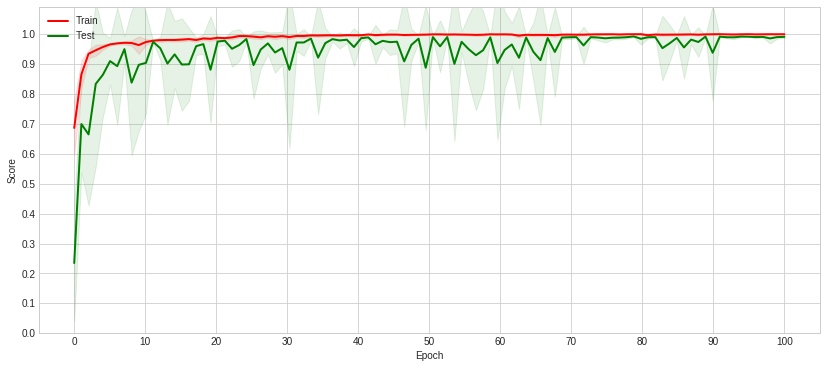

In [6]:
plot_mean_acc(history)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

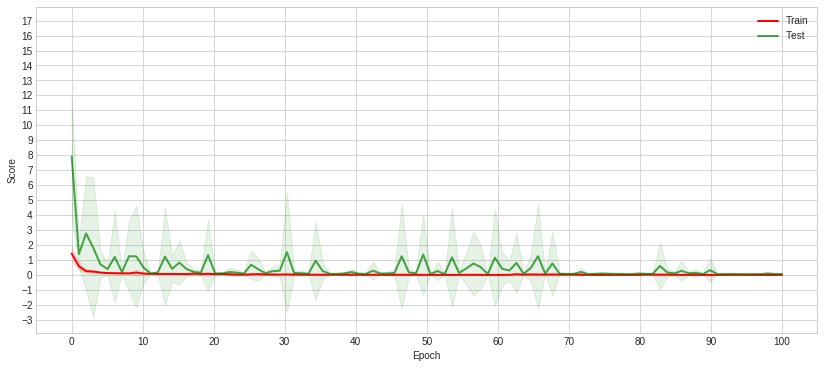

In [8]:
plot_mean_loss(history)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="large"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

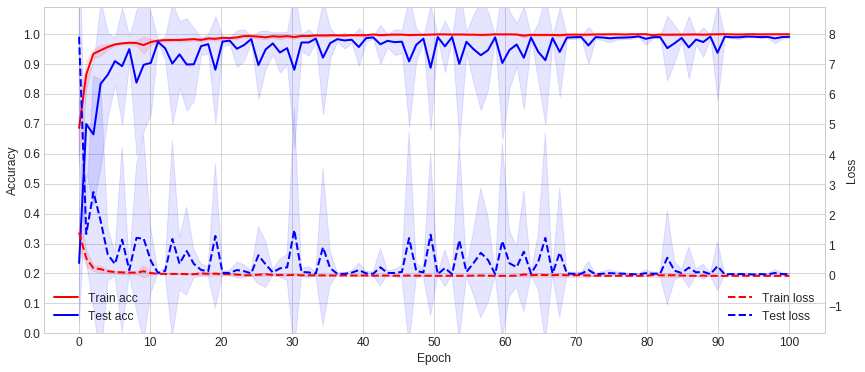

In [12]:
plot_mean(history)